In [23]:
%matplotlib inline
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
from data_loader import data_loaders as module_data
from model import loss as module_loss
from model import metric as module_metric
from model import model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
from utils import classActivationMap
import importlib
import math
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
importlib.reload(classActivationMap)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

Modules loaded
Reload complete
GPUs available: 1


In [24]:
resplit_data = False
if resplit_data:
    os.system('python3 utils/splitDataFolder.py -r "data/allDAPI_volume_0619/" -c "data/allDAPI_volume_0619/Label_all.csv" -s 0.15')
    
print("fin")

fin


In [25]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def set_instance(module, name, config, *args):
    setattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    print("Total number of training images = " + str(data_loader.dataset.data_len))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    torchsummary.summary(model, (1,7,32,32))
     
    
    if torch.cuda.is_available():
        print("Using GPU: " + torch.cuda.get_device_name(0))
    else:
        print("Using CPU to train")
    
    normalized = False
    util.visualizeBatch(data_loader, normalized)
    
    
    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
    criterion = loss(data_loader.dataset.weight.to(device)) # for imbalanced datasets
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    
    trainer = Trainer(model, criterion, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)
    
    
    findLR = False
    if findLR:
        #set lr = 1e-7 in config file 
        device_lr = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        lr_finder_training = lr_finder.LRFinder(model, optimizer, criterion, device=device_lr)
        lr_finder_training.range_test(data_loader, end_lr=1, num_iter=100, val_loader = valid_data_loader)
        lr_finder_training.plot(skip_start = 10, skip_end=5)
        # trim the first 10 and last 5 iteration from calculating loss (num_iter > skip_start + skip_end)
    else:
        trainer.train()
        a=1
    
 

In [26]:
config_file = '../configs/config_3d.json'

# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

Total number of training images = 1313
threeDmodel(
  (conv_layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, t

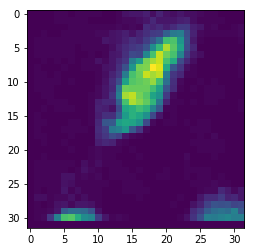

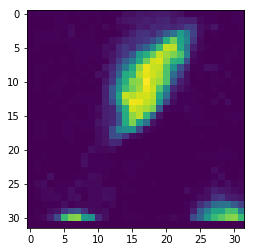

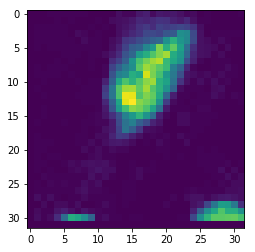

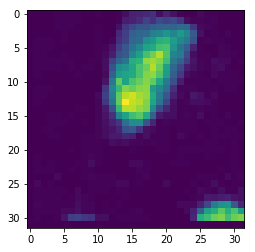

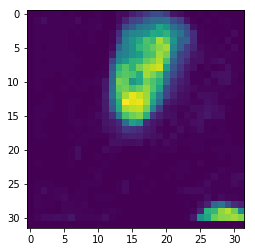

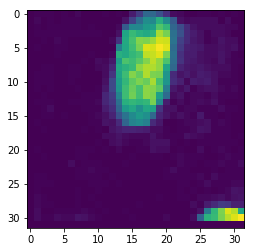

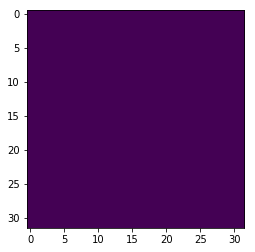

    epoch          : 1
    loss           : 0.8807333244217767
    my_metric      : 0.5537821087216249
    f1             : 0.5271597277793456
    balanced_accuracy: 0.5702263661999658
    precision      : 0.583559966220156
    recall         : 0.5537821087216249
    val_loss       : 1.0046977996826172
    val_my_metric  : 0.5287224264705882
    val_f1         : 0.3824301095004214
    val_balanced_accuracy: 0.5108176100628932
    val_precision  : 0.4340239868777207
    val_recall     : 0.5287224264705882
Saving checkpoint: saved/MaskedVolume_3d/0620_142107/checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 0.8500106864505343
    my_metric      : 0.5851347819593787
    f1             : 0.5774596363993391
    balanced_accuracy: 0.5958233558789298
    precision      : 0.6108304098132472
    recall         : 0.5851347819593787
    val_loss       : 0.914706826210022
    val_my_metric  : 0.4931066176470588
    val_f1         : 0.3815

Model has not improved in -------------| 1 epochs


    epoch          : 5
    loss           : 0.7655096915033128
    my_metric      : 0.5894750597371565
    f1             : 0.580860353255271
    balanced_accuracy: 0.5999121529250969
    precision      : 0.6158649667303996
    recall         : 0.5894750597371565
    val_loss       : 0.8559266030788422
    val_my_metric  : 0.5222886029411764
    val_f1         : 0.45292585017117903
    val_balanced_accuracy: 0.5655990351112302
    val_precision  : 0.6228226919045252
    val_recall     : 0.5222886029411764
Saving checkpoint: saved/MaskedVolume_3d/0620_142107/checkpoint-epoch5.pth ...
Saving current best: model_best.pth ...
    epoch          : 6
    loss           : 0.6909917857911851
    my_metric      : 0.6252893518518519
    f1             : 0.6219348139342519
    balanced_accuracy: 0.6329540604532387
    precision      : 0.6447496038889359
    recall         : 0.6252893518518519
    val_loss       : 0.9255858063697815
    val_my_metric  : 0.6247702205882353
    val_f1         : 0.59

Model has not improved in -------------| 1 epochs


    epoch          : 7
    loss           : 0.676862531238132
    my_metric      : 0.6655465949820789
    f1             : 0.6653692905442818
    balanced_accuracy: 0.6694418029961035
    precision      : 0.6748218569240587
    recall         : 0.6655465949820789
    val_loss       : 1.0080218613147736
    val_my_metric  : 0.5909926470588236
    val_f1         : 0.557827818627451
    val_balanced_accuracy: 0.6095488400899817
    val_precision  : 0.6660174996572055
    val_recall     : 0.5909926470588236


Model has not improved in -------------| 2 epochs


    epoch          : 8
    loss           : 0.6605122288068136
    my_metric      : 0.6559979838709677
    f1             : 0.6560411792287558
    balanced_accuracy: 0.6552698946003497
    precision      : 0.6614069791583665
    recall         : 0.6559979838709677
    val_loss       : 0.8001917004585266
    val_my_metric  : 0.6468290441176471
    val_f1         : 0.622560753191899
    val_balanced_accuracy: 0.6581124355096958
    val_precision  : 0.7302836099819943
    val_recall     : 0.6468290441176471
Saving checkpoint: saved/MaskedVolume_3d/0620_142107/checkpoint-epoch8.pth ...
Saving current best: model_best.pth ...
    epoch          : 9
    loss           : 0.6740103562672933
    my_metric      : 0.6389542264038233
    f1             : 0.6402913912402002
    balanced_accuracy: 0.6435996072081367
    precision      : 0.651534349800621
    recall         : 0.6389542264038233
    val_loss       : 0.8228653073310852
    val_my_metric  : 0.6036305147058824
    val_f1         : 0.5856

Model has not improved in -------------| 1 epochs


    epoch          : 10
    loss           : 0.6737624406814575
    my_metric      : 0.6679360812425329
    f1             : 0.668683721488976
    balanced_accuracy: 0.670124677514283
    precision      : 0.6746906655197423
    recall         : 0.6679360812425329
    val_loss       : 0.9816884994506836
    val_my_metric  : 0.6376378676470589
    val_f1         : 0.609894656221595
    val_balanced_accuracy: 0.6561169424183122
    val_precision  : 0.7211732890271494
    val_recall     : 0.6376378676470589


Model has not improved in -------------| 2 epochs


    epoch          : 11
    loss           : 0.6722382108370463
    my_metric      : 0.6635864695340502
    f1             : 0.6636876107836936
    balanced_accuracy: 0.6632852463830411
    precision      : 0.6678338672487237
    recall         : 0.6635864695340502
    val_loss       : 0.7015379965305328
    val_my_metric  : 0.6096047794117647
    val_f1         : 0.5819217879302268
    val_balanced_accuracy: 0.6207050939927652
    val_precision  : 0.6737037398499763
    val_recall     : 0.6096047794117647
Saving checkpoint: saved/MaskedVolume_3d/0620_142107/checkpoint-epoch11.pth ...
Saving current best: model_best.pth ...
    epoch          : 12
    loss           : 0.6613158782323202
    my_metric      : 0.6706429211469535
    f1             : 0.6712908168713664
    balanced_accuracy: 0.6703895621269734
    precision      : 0.6743664624401591
    recall         : 0.6706429211469535
    val_loss       : 0.6531947255134583
    val_my_metric  : 0.6624540441176471
    val_f1         : 0

Model has not improved in -------------| 1 epochs


    epoch          : 15
    loss           : 0.6343646380636427
    my_metric      : 0.7000541367980885
    f1             : 0.6996493080129075
    balanced_accuracy: 0.6992529094422418
    precision      : 0.7050598517128241
    recall         : 0.7000541367980885
    val_loss       : 0.7261696457862854
    val_my_metric  : 0.6801470588235294
    val_f1         : 0.6738482552730711
    val_balanced_accuracy: 0.693866519668217
    val_precision  : 0.7211605002092658
    val_recall     : 0.6801470588235294


Model has not improved in -------------| 2 epochs


    epoch          : 16
    loss           : 0.6298285325368246
    my_metric      : 0.6926803315412187
    f1             : 0.6928101877209305
    balanced_accuracy: 0.6931363109230335
    precision      : 0.6962832307167154
    recall         : 0.6926803315412187
    val_loss       : 0.708864152431488
    val_my_metric  : 0.6374080882352942
    val_f1         : 0.6321612945496804
    val_balanced_accuracy: 0.6443070628002135
    val_precision  : 0.6585278997962822
    val_recall     : 0.6374080882352942


Model has not improved in -------------| 3 epochs


    epoch          : 17
    loss           : 0.6173248754607307
    my_metric      : 0.6881160394265233
    f1             : 0.6887177886899405
    balanced_accuracy: 0.689865973965929
    precision      : 0.6945276643865815
    recall         : 0.6881160394265233
    val_loss       : 0.598656177520752
    val_my_metric  : 0.7010569852941176
    val_f1         : 0.7029624370213583
    val_balanced_accuracy: 0.7084907280219781
    val_precision  : 0.7180339275792047
    val_recall     : 0.7010569852941176
Saving checkpoint: saved/MaskedVolume_3d/0620_142107/checkpoint-epoch17.pth ...
Saving current best: model_best.pth ...
    epoch          : 18
    loss           : 0.6031951308250427
    my_metric      : 0.7026583034647551
    f1             : 0.7036236038573342
    balanced_accuracy: 0.7075104768727054
    precision      : 0.7140270438835528
    recall         : 0.7026583034647551
    val_loss       : 0.6110881567001343
    val_my_metric  : 0.6746323529411764
    val_f1         : 0.6

Model has not improved in -------------| 1 epochs


    epoch          : 19
    loss           : 0.6020961801211039
    my_metric      : 0.7084173387096775
    f1             : 0.7081125870229421
    balanced_accuracy: 0.7080207666964081
    precision      : 0.7108733958820092
    recall         : 0.7084173387096775
    val_loss       : 0.5712150037288666
    val_my_metric  : 0.7568933823529411
    val_f1         : 0.7563802459877662
    val_balanced_accuracy: 0.7584346589906263
    val_precision  : 0.7650635218915067
    val_recall     : 0.7568933823529411
Saving checkpoint: saved/MaskedVolume_3d/0620_142107/checkpoint-epoch19.pth ...
Saving current best: model_best.pth ...
    epoch          : 20
    loss           : 0.5851434138086107
    my_metric      : 0.6995221027479093
    f1             : 0.7002562506105847
    balanced_accuracy: 0.702449203525586
    precision      : 0.7072340449669249
    recall         : 0.6995221027479093
    val_loss       : 0.6351340413093567
    val_my_metric  : 0.6741727941176471
    val_f1         : 0.

Model has not improved in -------------| 1 epochs


    epoch          : 21
    loss           : 0.6228746175765991
    my_metric      : 0.7026583034647551
    f1             : 0.7024888147098015
    balanced_accuracy: 0.7016162744716828
    precision      : 0.7072908434453564
    recall         : 0.7026583034647551
    val_loss       : 0.6380231380462646
    val_my_metric  : 0.6663602941176471
    val_f1         : 0.6599799808622079
    val_balanced_accuracy: 0.6888342912733156
    val_precision  : 0.7229620207171397
    val_recall     : 0.6663602941176471


Model has not improved in -------------| 2 epochs


    epoch          : 22
    loss           : 0.6099163426293267
    my_metric      : 0.7172005675029869
    f1             : 0.7178200166879848
    balanced_accuracy: 0.7192700410592896
    precision      : 0.7226749782909244
    recall         : 0.7172005675029869
    val_loss       : 0.6155665516853333
    val_my_metric  : 0.68359375
    val_f1         : 0.6816383326987264
    val_balanced_accuracy: 0.6887564490304217
    val_precision  : 0.7018856296200047
    val_recall     : 0.68359375


Model has not improved in -------------| 3 epochs


    epoch          : 23
    loss           : 0.5921719272931417
    my_metric      : 0.7180592891278376
    f1             : 0.7184066820942652
    balanced_accuracy: 0.7189795783032655
    precision      : 0.7227501881755699
    recall         : 0.7180592891278376
    val_loss       : 0.6311928331851959
    val_my_metric  : 0.7024356617647058
    val_f1         : 0.7018064687364034
    val_balanced_accuracy: 0.7087660782703886
    val_precision  : 0.7171617569983968
    val_recall     : 0.7024356617647058


Model has not improved in -------------| 4 epochs


    epoch          : 24
    loss           : 0.5792652037408617
    my_metric      : 0.7242476851851852
    f1             : 0.723767219034784
    balanced_accuracy: 0.7233522946217619
    precision      : 0.7276529323490005
    recall         : 0.7242476851851852
    val_loss       : 0.5988563299179077
    val_my_metric  : 0.7348345588235294
    val_f1         : 0.7353615925536882
    val_balanced_accuracy: 0.7352899774774775
    val_precision  : 0.7391579835957371
    val_recall     : 0.7348345588235294


Model has not improved in -------------| 5 epochs


    epoch          : 25
    loss           : 0.5821642610761855
    my_metric      : 0.7286999701314217
    f1             : 0.7295762676944595
    balanced_accuracy: 0.7329024130534053
    precision      : 0.7377586662398631
    recall         : 0.7286999701314217
    val_loss       : 0.590374767780304
    val_my_metric  : 0.7373621323529411
    val_f1         : 0.7374127375893691
    val_balanced_accuracy: 0.7371130030959753
    val_precision  : 0.7393621137888406
    val_recall     : 0.7373621323529411


Model has not improved in -------------| 6 epochs


    epoch          : 26
    loss           : 0.5944201383325789
    my_metric      : 0.7194687126642773
    f1             : 0.7199698512983745
    balanced_accuracy: 0.7197717466302145
    precision      : 0.7226824379620523
    recall         : 0.7194687126642773
    val_loss       : 0.6380762755870819
    val_my_metric  : 0.6946231617647058
    val_f1         : 0.6929036955691368
    val_balanced_accuracy: 0.7126234650624894
    val_precision  : 0.7332396187035861
    val_recall     : 0.6946231617647058


Model has not improved in -------------| 7 epochs


    epoch          : 27
    loss           : 0.5754822724395328
    my_metric      : 0.725554435483871
    f1             : 0.7252367367622838
    balanced_accuracy: 0.7236119463067557
    precision      : 0.7301626577131063
    recall         : 0.725554435483871
    val_loss       : 0.622854620218277
    val_my_metric  : 0.6907169117647058
    val_f1         : 0.6886494080582566
    val_balanced_accuracy: 0.703185658427594
    val_precision  : 0.722648043592437
    val_recall     : 0.6907169117647058


Model has not improved in -------------| 8 epochs


    epoch          : 28
    loss           : 0.5864875051710341
    my_metric      : 0.7197020609318997
    f1             : 0.7205718830329855
    balanced_accuracy: 0.7234848974372607
    precision      : 0.7272633902044523
    recall         : 0.7197020609318997
    val_loss       : 0.5873148143291473
    val_my_metric  : 0.7192095588235294
    val_f1         : 0.7188829710769938
    val_balanced_accuracy: 0.7229206178057179
    val_precision  : 0.728683803789367
    val_recall     : 0.7192095588235294


Model has not improved in -------------| 9 epochs


    epoch          : 29
    loss           : 0.5762070814768473
    my_metric      : 0.7138310185185186
    f1             : 0.7138706065372888
    balanced_accuracy: 0.713859795465623
    precision      : 0.7158540581535617
    recall         : 0.7138310185185186
    val_loss       : 0.605605810880661
    val_my_metric  : 0.7045036764705883
    val_f1         : 0.704684862286552
    val_balanced_accuracy: 0.7069042645024854
    val_precision  : 0.7100697104759012
    val_recall     : 0.7045036764705883


Model has not improved in -------------| 10 epochs


    epoch          : 30
    loss           : 0.5897506674130758
    my_metric      : 0.7253397550776584
    f1             : 0.7260065893564067
    balanced_accuracy: 0.7270389169269316
    precision      : 0.7304413508910756
    recall         : 0.7253397550776584
    val_loss       : 0.5958162546157837
    val_my_metric  : 0.7063419117647058
    val_f1         : 0.7051718816207013
    val_balanced_accuracy: 0.7028982107107108
    val_precision  : 0.7098644270461221
    val_recall     : 0.7063419117647058


Model has not improved in -------------| 11 epochs


    epoch          : 31
    loss           : 0.5958355996343825
    my_metric      : 0.7218675328554361
    f1             : 0.7208538950598812
    balanced_accuracy: 0.7196644738896281
    precision      : 0.722784717598195
    recall         : 0.7218675328554361
    val_loss       : 0.5463483333587646
    val_my_metric  : 0.7309283088235294
    val_f1         : 0.7313127612105088
    val_balanced_accuracy: 0.734249226006192
    val_precision  : 0.7378514631935396
    val_recall     : 0.7309283088235294
Saving checkpoint: saved/MaskedVolume_3d/0620_142107/checkpoint-epoch31.pth ...
Saving current best: model_best.pth ...
    epoch          : 32
    loss           : 0.5593082043859694
    my_metric      : 0.7335816158900836
    f1             : 0.7339543883625246
    balanced_accuracy: 0.7357779392994561
    precision      : 0.7388903999083153
    recall         : 0.7335816158900836
    val_loss       : 0.5672415494918823
    val_my_metric  : 0.7426470588235294
    val_f1         : 0.7

Model has not improved in -------------| 1 epochs


    epoch          : 33
    loss           : 0.589318487379286
    my_metric      : 0.712318921744325
    f1             : 0.7118394068898328
    balanced_accuracy: 0.7100780432350725
    precision      : 0.7132391430126225
    recall         : 0.712318921744325
    val_loss       : 0.5673704445362091
    val_my_metric  : 0.7157628676470589
    val_f1         : 0.7171201647775343
    val_balanced_accuracy: 0.725989010989011
    val_precision  : 0.7420889619754637
    val_recall     : 0.7157628676470589


Model has not improved in -------------| 2 epochs


    epoch          : 34
    loss           : 0.5755350258615282
    my_metric      : 0.7236036439665472
    f1             : 0.724465359845466
    balanced_accuracy: 0.7284469023839998
    precision      : 0.7335068129262119
    recall         : 0.7236036439665472
    val_loss       : 0.5800924599170685
    val_my_metric  : 0.7235753676470589
    val_f1         : 0.7203236419364938
    val_balanced_accuracy: 0.7165247678018576
    val_precision  : 0.7278066764640087
    val_recall     : 0.7235753676470589


Model has not improved in -------------| 3 epochs


    epoch          : 35
    loss           : 0.5742767519421048
    my_metric      : 0.7274025537634409
    f1             : 0.727969078070865
    balanced_accuracy: 0.7288590806786299
    precision      : 0.7314703720712724
    recall         : 0.7274025537634409
    val_loss       : 0.5668628811836243
    val_my_metric  : 0.7079503676470589
    val_f1         : 0.7032200452692865
    val_balanced_accuracy: 0.6966150895303886
    val_precision  : 0.7100047174409536
    val_recall     : 0.7079503676470589


Model has not improved in -------------| 4 epochs


    epoch          : 36
    loss           : 0.5514115922980838
    my_metric      : 0.7299040471923537
    f1             : 0.7308381586859728
    balanced_accuracy: 0.7314823629206514
    precision      : 0.7356436059427058
    recall         : 0.7299040471923537
    val_loss       : 0.5846396386623383
    val_my_metric  : 0.74609375
    val_f1         : 0.7451464523110316
    val_balanced_accuracy: 0.7510091680350302
    val_precision  : 0.7600437122159683
    val_recall     : 0.74609375


Model has not improved in -------------| 5 epochs


    epoch          : 37
    loss           : 0.5601639052232107
    my_metric      : 0.7358684289127838
    f1             : 0.7361578003102367
    balanced_accuracy: 0.7373444327891743
    precision      : 0.7410534210128391
    recall         : 0.7358684289127838
    val_loss       : 0.5873020589351654
    val_my_metric  : 0.7171415441176471
    val_f1         : 0.7180553809309984
    val_balanced_accuracy: 0.7333018543956044
    val_precision  : 0.7490430561752472
    val_recall     : 0.7171415441176471


Model has not improved in -------------| 6 epochs


    epoch          : 38
    loss           : 0.5544076297018263
    my_metric      : 0.7418328106332139
    f1             : 0.7420926081128603
    balanced_accuracy: 0.7413348002030443
    precision      : 0.7435332491397134
    recall         : 0.7418328106332139
    val_loss       : 0.5913345813751221
    val_my_metric  : 0.7318474264705883
    val_f1         : 0.7320479742992088
    val_balanced_accuracy: 0.731371442255063
    val_precision  : 0.7326646135882784
    val_recall     : 0.7318474264705883


Model has not improved in -------------| 7 epochs


    epoch          : 39
    loss           : 0.544860002067354
    my_metric      : 0.7460704151732378
    f1             : 0.7469605513465463
    balanced_accuracy: 0.7486393447880749
    precision      : 0.7527265887029249
    recall         : 0.7460704151732378
    val_loss       : 0.6045155227184296
    val_my_metric  : 0.7141544117647058
    val_f1         : 0.7146203624411641
    val_balanced_accuracy: 0.7165558717250067
    val_precision  : 0.7190440074631251
    val_recall     : 0.7141544117647058


Model has not improved in -------------| 8 epochs


    epoch          : 40
    loss           : 0.5667035910818312
    my_metric      : 0.7227355884109916
    f1             : 0.7221946624614451
    balanced_accuracy: 0.7203627602022182
    precision      : 0.7240912281822995
    recall         : 0.7227355884109916
    val_loss       : 0.5921364724636078
    val_my_metric  : 0.7015165441176471
    val_f1         : 0.6985935973603132
    val_balanced_accuracy: 0.7143890388471609
    val_precision  : 0.7344410771485932
    val_recall     : 0.7015165441176471


Model has not improved in -------------| 9 epochs


    epoch          : 41
    loss           : 0.5578809744781918
    my_metric      : 0.7060185185185186
    f1             : 0.7056777520067721
    balanced_accuracy: 0.7097296814948703
    precision      : 0.7150772457069232
    recall         : 0.7060185185185186
    val_loss       : 0.5967756509780884
    val_my_metric  : 0.7139246323529411
    val_f1         : 0.7129243131422762
    val_balanced_accuracy: 0.7197022646244291
    val_precision  : 0.7294454109768908
    val_recall     : 0.7139246323529411


Model has not improved in -------------| 10 epochs


    epoch          : 42
    loss           : 0.5637087292141385
    my_metric      : 0.7130749701314217
    f1             : 0.7133863172087316
    balanced_accuracy: 0.7145166918094603
    precision      : 0.7179305492837273
    recall         : 0.7130749701314217
    val_loss       : 0.5737836062908173
    val_my_metric  : 0.7054227941176471
    val_f1         : 0.6981155119285815
    val_balanced_accuracy: 0.7134554942774121
    val_precision  : 0.7411775148047369
    val_recall     : 0.7054227941176471


Model has not improved in -------------| 11 epochs


    epoch          : 43
    loss           : 0.5585448874367608
    my_metric      : 0.7398820191158901
    f1             : 0.7401016935732407
    balanced_accuracy: 0.7414747189283146
    precision      : 0.7455442568150654
    recall         : 0.7398820191158901
    val_loss       : 0.7243993878364563
    val_my_metric  : 0.6482077205882353
    val_f1         : 0.6337983183795126
    val_balanced_accuracy: 0.6715718057103273
    val_precision  : 0.7197622152058498
    val_recall     : 0.6482077205882353


Model has not improved in -------------| 12 epochs


    epoch          : 44
    loss           : 0.5432950258255005
    my_metric      : 0.7276172341696535
    f1             : 0.7280158752189477
    balanced_accuracy: 0.7310289584764202
    precision      : 0.7347745739685476
    recall         : 0.7276172341696535
    val_loss       : 0.6065057218074799
    val_my_metric  : 0.7392003676470589
    val_f1         : 0.739249816749362
    val_balanced_accuracy: 0.740920053366174
    val_precision  : 0.7436395353791394
    val_recall     : 0.7392003676470589


Model has not improved in -------------| 13 epochs


    epoch          : 45
    loss           : 0.5652712881565094
    my_metric      : 0.7092760603345281
    f1             : 0.708618515143145
    balanced_accuracy: 0.7081992962066416
    precision      : 0.7127546603321777
    recall         : 0.7092760603345281
    val_loss       : 0.6048516631126404
    val_my_metric  : 0.6888786764705883
    val_f1         : 0.6877247711421098
    val_balanced_accuracy: 0.6942110177404295
    val_precision  : 0.7028521825396825
    val_recall     : 0.6888786764705883


Model has not improved in -------------| 14 epochs


    epoch          : 46
    loss           : 0.5607853333155314
    my_metric      : 0.7197020609318997
    f1             : 0.7199954636855888
    balanced_accuracy: 0.7227209107762216
    precision      : 0.7265310329710923
    recall         : 0.7197020609318997
    val_loss       : 0.5692145228385925
    val_my_metric  : 0.6863511029411764
    val_f1         : 0.682832697060993
    val_balanced_accuracy: 0.6934815592903829
    val_precision  : 0.7075506435571157
    val_recall     : 0.6863511029411764


Model has not improved in -------------| 15 epochs


    epoch          : 47
    loss           : 0.5461200541920133
    my_metric      : 0.7462850955794504
    f1             : 0.7467868729156418
    balanced_accuracy: 0.7477068315106097
    precision      : 0.7505613381533072
    recall         : 0.7462850955794504
    val_loss       : 0.5576151311397552
    val_my_metric  : 0.7486213235294117
    val_f1         : 0.7487663174244057
    val_balanced_accuracy: 0.7532817125490718
    val_precision  : 0.7578955980139854
    val_recall     : 0.7486213235294117


Model has not improved in -------------| 16 epochs


    epoch          : 48
    loss           : 0.5709018508593241
    my_metric      : 0.739340651135006
    f1             : 0.7387888343090666
    balanced_accuracy: 0.7380076134342906
    precision      : 0.741362436337869
    recall         : 0.739340651135006
    val_loss       : 0.5780474245548248
    val_my_metric  : 0.7318474264705883
    val_f1         : 0.7308838184996415
    val_balanced_accuracy: 0.7432443059304512
    val_precision  : 0.7565858947570476
    val_recall     : 0.7318474264705883


Model has not improved in -------------| 17 epochs


    epoch          : 49
    loss           : 0.5553426610098945
    my_metric      : 0.7386872759856631
    f1             : 0.7391821966086962
    balanced_accuracy: 0.7406920110094597
    precision      : 0.743755369586015
    recall         : 0.7386872759856631
    val_loss       : 0.5775277316570282
    val_my_metric  : 0.7201286764705883
    val_f1         : 0.7152181846065921
    val_balanced_accuracy: 0.7104717335301879
    val_precision  : 0.7236411025213774
    val_recall     : 0.7201286764705883


Model has not improved in -------------| 18 epochs


    epoch          : 50
    loss           : 0.549823628531562
    my_metric      : 0.7454170400238949
    f1             : 0.7456112360727557
    balanced_accuracy: 0.7457411298501071
    precision      : 0.7481402428805165
    recall         : 0.7454170400238949
    val_loss       : 0.5339867621660233
    val_my_metric  : 0.7711397058823529
    val_f1         : 0.7714452826585179
    val_balanced_accuracy: 0.7788224377958015
    val_precision  : 0.7848256530784806
    val_recall     : 0.7711397058823529
Saving checkpoint: saved/MaskedVolume_3d/0620_142107/checkpoint-epoch50.pth ...
Saving current best: model_best.pth ...
    epoch          : 51
    loss           : 0.5430727865960863
    my_metric      : 0.7598472968936679
    f1             : 0.7606396162917909
    balanced_accuracy: 0.7622051964147241
    precision      : 0.76585584770316
    recall         : 0.7598472968936679
    val_loss       : 0.5531841516494751
    val_my_metric  : 0.7525275735294117
    val_f1         : 0.75

Model has not improved in -------------| 1 epochs


    epoch          : 52
    loss           : 0.5336144268512726
    my_metric      : 0.7712440262843488
    f1             : 0.771437788536161
    balanced_accuracy: 0.7713807484056568
    precision      : 0.7730343082200554
    recall         : 0.7712440262843488
    val_loss       : 0.6117287576198578
    val_my_metric  : 0.7010569852941176
    val_f1         : 0.7015608053603679
    val_balanced_accuracy: 0.7022022022022022
    val_precision  : 0.706909463693973
    val_recall     : 0.7010569852941176


Model has not improved in -------------| 2 epochs


    epoch          : 53
    loss           : 0.5429303646087646
    my_metric      : 0.7549563172043011
    f1             : 0.7552181663106354
    balanced_accuracy: 0.7571132745663687
    precision      : 0.761831864086772
    recall         : 0.7549563172043011
    val_loss       : 0.621844470500946
    val_my_metric  : 0.7318474264705883
    val_f1         : 0.7333028004981976
    val_balanced_accuracy: 0.7165007664113953
    val_precision  : 0.7432947188159684
    val_recall     : 0.7318474264705883


Model has not improved in -------------| 3 epochs


    epoch          : 54
    loss           : 0.5544422103299035
    my_metric      : 0.7269638590203107
    f1             : 0.727286771093811
    balanced_accuracy: 0.7274151318999134
    precision      : 0.7299062507528477
    recall         : 0.7269638590203107
    val_loss       : 0.5948282480239868
    val_my_metric  : 0.7274816176470589
    val_f1         : 0.7276300377875409
    val_balanced_accuracy: 0.7286828094070943
    val_precision  : 0.7356472877612583
    val_recall     : 0.7274816176470589


Model has not improved in -------------| 4 epochs


    epoch          : 55
    loss           : 0.5404888557063209
    my_metric      : 0.7364097968936679
    f1             : 0.7364980238576474
    balanced_accuracy: 0.7367649610910223
    precision      : 0.7389304885311296
    recall         : 0.7364097968936679
    val_loss       : 0.6337502002716064
    val_my_metric  : 0.6937040441176471
    val_f1         : 0.6893401093841264
    val_balanced_accuracy: 0.7046986179529282
    val_precision  : 0.7246414017279943
    val_recall     : 0.6937040441176471


Model has not improved in -------------| 5 epochs


    epoch          : 56
    loss           : 0.5504660507043203
    my_metric      : 0.7452023596176822
    f1             : 0.7456396886126426
    balanced_accuracy: 0.7460712235348577
    precision      : 0.7484369257948852
    recall         : 0.7452023596176822
    val_loss       : 0.571104884147644
    val_my_metric  : 0.7504595588235294
    val_f1         : 0.7502026964418087
    val_balanced_accuracy: 0.7495915032679739
    val_precision  : 0.7527034180278283
    val_recall     : 0.7504595588235294


Model has not improved in -------------| 6 epochs


    epoch          : 57
    loss           : 0.5445643895202212
    my_metric      : 0.7314161439665472
    f1             : 0.7317227963568284
    balanced_accuracy: 0.7335243749865994
    precision      : 0.7374422097469545
    recall         : 0.7314161439665472
    val_loss       : 0.5816116333007812
    val_my_metric  : 0.76171875
    val_f1         : 0.759857645631677
    val_balanced_accuracy: 0.7669018541324576
    val_precision  : 0.7800112250475623
    val_recall     : 0.76171875


Model has not improved in -------------| 7 epochs


    epoch          : 58
    loss           : 0.5378340979417165
    my_metric      : 0.7368484916367981
    f1             : 0.7378266509232464
    balanced_accuracy: 0.7399724625210388
    precision      : 0.7444219200621612
    recall         : 0.7368484916367981
    val_loss       : 0.6149451434612274
    val_my_metric  : 0.7088694852941176
    val_f1         : 0.7088417800730529
    val_balanced_accuracy: 0.7078587846886037
    val_precision  : 0.7105600857070771
    val_recall     : 0.7088694852941176


Model has not improved in -------------| 8 epochs


    epoch          : 59
    loss           : 0.5512424144479964
    my_metric      : 0.7626661439665472
    f1             : 0.7627973850407976
    balanced_accuracy: 0.7632058401148591
    precision      : 0.7652089833324712
    recall         : 0.7626661439665472
    val_loss       : 0.6365813314914703
    val_my_metric  : 0.6927849264705883
    val_f1         : 0.6860009103029592
    val_balanced_accuracy: 0.7060907449870295
    val_precision  : 0.7341322281541804
    val_recall     : 0.6927849264705883


Model has not improved in -------------| 9 epochs


    epoch          : 60
    loss           : 0.5247660974661509
    my_metric      : 0.7521374701314217
    f1             : 0.752376889101203
    balanced_accuracy: 0.7531347717900994
    precision      : 0.7557458097945187
    recall         : 0.7521374701314217
    val_loss       : 0.6217743158340454
    val_my_metric  : 0.6858915441176471
    val_f1         : 0.6820149568091051
    val_balanced_accuracy: 0.6770173029274639
    val_precision  : 0.6887568196500646
    val_recall     : 0.6858915441176471


Model has not improved in -------------| 10 epochs


    epoch          : 61
    loss           : 0.5283457769287957
    my_metric      : 0.7608366935483871
    f1             : 0.7609932969307324
    balanced_accuracy: 0.7624816599705846
    precision      : 0.76413518690031
    recall         : 0.7608366935483871
    val_loss       : 0.5485580563545227
    val_my_metric  : 0.7750459558823529
    val_f1         : 0.7747704310731927
    val_balanced_accuracy: 0.782985036119711
    val_precision  : 0.7914776650096659
    val_recall     : 0.7750459558823529


Model has not improved in -------------| 11 epochs


    epoch          : 62
    loss           : 0.5164343946509891
    my_metric      : 0.7582231929510156
    f1             : 0.758632535647791
    balanced_accuracy: 0.7601013353288164
    precision      : 0.7627137055705916
    recall         : 0.7582231929510156
    val_loss       : 0.5792863368988037
    val_my_metric  : 0.7490808823529411
    val_f1         : 0.7491185735977777
    val_balanced_accuracy: 0.747926195385011
    val_precision  : 0.750027347308694
    val_recall     : 0.7490808823529411


Model has not improved in -------------| 12 epochs


    epoch          : 63
    loss           : 0.5416346424155765
    my_metric      : 0.7458557347670252
    f1             : 0.7462127939497744
    balanced_accuracy: 0.7476180943348067
    precision      : 0.7515513859955267
    recall         : 0.7458557347670252
    val_loss       : 0.5482237040996552
    val_my_metric  : 0.7509191176470589
    val_f1         : 0.7510524518042825
    val_balanced_accuracy: 0.7558565531475749
    val_precision  : 0.7620499904507257
    val_recall     : 0.7509191176470589


Model has not improved in -------------| 13 epochs


    epoch          : 64
    loss           : 0.5455563565095266
    my_metric      : 0.7491039426523298
    f1             : 0.7497516887220673
    balanced_accuracy: 0.7520941625080916
    precision      : 0.7574630915254854
    recall         : 0.7491039426523298
    val_loss       : 0.5326287895441055
    val_my_metric  : 0.7897518382352942
    val_f1         : 0.7902950694077373
    val_balanced_accuracy: 0.7942151455850086
    val_precision  : 0.7983647365196078
    val_recall     : 0.7897518382352942
Saving checkpoint: saved/MaskedVolume_3d/0620_142107/checkpoint-epoch64.pth ...
Saving current best: model_best.pth ...
    epoch          : 65
    loss           : 0.5345866117212508
    my_metric      : 0.7395553315412187
    f1             : 0.7402275731382867
    balanced_accuracy: 0.744687398079737
    precision      : 0.7496836662716364
    recall         : 0.7395553315412187
    val_loss       : 0.588705986738205
    val_my_metric  : 0.7123161764705883
    val_f1         : 0.7

Model has not improved in -------------| 1 epochs


    epoch          : 66
    loss           : 0.5447786251703898
    my_metric      : 0.7397700119474313
    f1             : 0.7396871905620713
    balanced_accuracy: 0.7413674768767643
    precision      : 0.7473390393124084
    recall         : 0.7397700119474313
    val_loss       : 0.5058154463768005
    val_my_metric  : 0.7927389705882353
    val_f1         : 0.7930964203694821
    val_balanced_accuracy: 0.7908377127127126
    val_precision  : 0.7981289390756303
    val_recall     : 0.7927389705882353
Saving checkpoint: saved/MaskedVolume_3d/0620_142107/checkpoint-epoch66.pth ...
Saving current best: model_best.pth ...
    epoch          : 67
    loss           : 0.5461070504453447
    my_metric      : 0.7213168309438471
    f1             : 0.7220860598176385
    balanced_accuracy: 0.724785626044054
    precision      : 0.728944955862115
    recall         : 0.7213168309438471
    val_loss       : 0.59028160572052
    val_my_metric  : 0.7005974264705883
    val_f1         : 0.700

Model has not improved in -------------| 1 epochs


    epoch          : 68
    loss           : 0.5252646108468374
    my_metric      : 0.7522588112305855
    f1             : 0.7527356300442187
    balanced_accuracy: 0.7528530717639172
    precision      : 0.7561924078138362
    recall         : 0.7522588112305855
    val_loss       : 0.5612102746963501
    val_my_metric  : 0.7288602941176471
    val_f1         : 0.7288602941176471
    val_balanced_accuracy: 0.727395954675421
    val_precision  : 0.7288602941176471
    val_recall     : 0.7288602941176471


Model has not improved in -------------| 2 epochs


    epoch          : 69
    loss           : 0.5236761503749423
    my_metric      : 0.7676597968936679
    f1             : 0.7678894179952416
    balanced_accuracy: 0.7682043950695685
    precision      : 0.769480483414687
    recall         : 0.7676597968936679
    val_loss       : 0.5405814945697784
    val_my_metric  : 0.7362132352941176
    val_f1         : 0.7297426367610259
    val_balanced_accuracy: 0.7389047026033327
    val_precision  : 0.7611054291834641
    val_recall     : 0.7362132352941176


Model has not improved in -------------| 3 epochs


    epoch          : 70
    loss           : 0.5177409615781572
    my_metric      : 0.745958408004779
    f1             : 0.7461975533846833
    balanced_accuracy: 0.7506054681537713
    precision      : 0.7551719342376969
    recall         : 0.745958408004779
    val_loss       : 0.5821318626403809
    val_my_metric  : 0.7107077205882353
    val_f1         : 0.7103227920378823
    val_balanced_accuracy: 0.7151104393506172
    val_precision  : 0.719242010126419
    val_recall     : 0.7107077205882353


Model has not improved in -------------| 4 epochs


    epoch          : 71
    loss           : 0.5186279714107513
    my_metric      : 0.756160394265233
    f1             : 0.7565661006000531
    balanced_accuracy: 0.7591433050803807
    precision      : 0.7618780478520795
    recall         : 0.756160394265233
    val_loss       : 0.5787172913551331
    val_my_metric  : 0.6879595588235294
    val_f1         : 0.6869131945300115
    val_balanced_accuracy: 0.6944222085385878
    val_precision  : 0.7018892392779776
    val_recall     : 0.6879595588235294


Model has not improved in -------------| 5 epochs


    epoch          : 72
    loss           : 0.5205516815185547
    my_metric      : 0.75735513739546
    f1             : 0.757646036800195
    balanced_accuracy: 0.7592530877355175
    precision      : 0.7631099269120787
    recall         : 0.75735513739546
    val_loss       : 0.6200090944766998
    val_my_metric  : 0.6985294117647058
    val_f1         : 0.6970621553779774
    val_balanced_accuracy: 0.7098180878881671
    val_precision  : 0.7232629998814822
    val_recall     : 0.6985294117647058


Model has not improved in -------------| 6 epochs


    epoch          : 73
    loss           : 0.5223174492518107
    my_metric      : 0.7586525537634409
    f1             : 0.7588417786310149
    balanced_accuracy: 0.7606935146240282
    precision      : 0.7634438981226126
    recall         : 0.7586525537634409
    val_loss       : 0.6069227159023285
    val_my_metric  : 0.7249540441176471
    val_f1         : 0.7247875648193163
    val_balanced_accuracy: 0.7294246646026832
    val_precision  : 0.7378629545602925
    val_recall     : 0.7249540441176471


Model has not improved in -------------| 7 epochs


    epoch          : 74
    loss           : 0.5319035053253174
    my_metric      : 0.7521468040621266
    f1             : 0.752854343737691
    balanced_accuracy: 0.7551206814316456
    precision      : 0.7588486805218412
    recall         : 0.7521468040621266
    val_loss       : 0.5884522199630737
    val_my_metric  : 0.7093290441176471
    val_f1         : 0.707835950412015
    val_balanced_accuracy: 0.70417008757526
    val_precision  : 0.7092033434187072
    val_recall     : 0.7093290441176471


Model has not improved in -------------| 8 epochs


    epoch          : 75
    loss           : 0.5197535753250122
    my_metric      : 0.7565990890083633
    f1             : 0.7567409310222739
    balanced_accuracy: 0.7603382007668645
    precision      : 0.764685484489289
    recall         : 0.7565990890083633
    val_loss       : 0.5966105759143829
    val_my_metric  : 0.7166819852941176
    val_f1         : 0.709264275197808
    val_balanced_accuracy: 0.702128787293692
    val_precision  : 0.7236598428279415
    val_recall     : 0.7166819852941176


Model has not improved in -------------| 9 epochs


    epoch          : 76
    loss           : 0.5279617442025079
    my_metric      : 0.7645142622461171
    f1             : 0.7651453276401425
    balanced_accuracy: 0.76614137655416
    precision      : 0.7687933550887684
    recall         : 0.7645142622461171
    val_loss       : 0.5774874091148376
    val_my_metric  : 0.76171875
    val_f1         : 0.7618864601451151
    val_balanced_accuracy: 0.7653814581929256
    val_precision  : 0.7692743378411202
    val_recall     : 0.76171875


Model has not improved in -------------| 10 epochs


    epoch          : 77
    loss           : 0.5200884607103136
    my_metric      : 0.7586525537634409
    f1             : 0.7588620666080842
    balanced_accuracy: 0.7587629470343681
    precision      : 0.7601433275607229
    recall         : 0.7586525537634409
    val_loss       : 0.5584878027439117
    val_my_metric  : 0.7690716911764706
    val_f1         : 0.7701590777517682
    val_balanced_accuracy: 0.7695026327838828
    val_precision  : 0.7750712393711314
    val_recall     : 0.7690716911764706


Model has not improved in -------------| 11 epochs


    epoch          : 78
    loss           : 0.5119484629895952
    my_metric      : 0.7740628733572282
    f1             : 0.7746019735850975
    balanced_accuracy: 0.7778171254267884
    precision      : 0.7818731790837505
    recall         : 0.7740628733572282
    val_loss       : 0.5759782493114471
    val_my_metric  : 0.7357536764705883
    val_f1         : 0.7340596064949718
    val_balanced_accuracy: 0.7414998973727422
    val_precision  : 0.7513257664615587
    val_recall     : 0.7357536764705883


Model has not improved in -------------| 12 epochs


    epoch          : 79
    loss           : 0.5059291157457564
    my_metric      : 0.7586618876941458
    f1             : 0.7588310934691287
    balanced_accuracy: 0.7588327003657345
    precision      : 0.7611118690570274
    recall         : 0.7586618876941458
    val_loss       : 0.6217353641986847
    val_my_metric  : 0.7274816176470589
    val_f1         : 0.7250926873914123
    val_balanced_accuracy: 0.7227806855500821
    val_precision  : 0.7306895519835841
    val_recall     : 0.7274816176470589


Model has not improved in -------------| 13 epochs


    epoch          : 80
    loss           : 0.4991712172826131
    my_metric      : 0.776013664874552
    f1             : 0.7766122855061931
    balanced_accuracy: 0.7765276160396545
    precision      : 0.7792764472248114
    recall         : 0.776013664874552
    val_loss       : 0.578714907169342
    val_my_metric  : 0.7240349264705883
    val_f1         : 0.7247015756452346
    val_balanced_accuracy: 0.7309960201089234
    val_precision  : 0.7388783433746615
    val_recall     : 0.7240349264705883


Model has not improved in -------------| 14 epochs


    epoch          : 81
    loss           : 0.5035188032521142
    my_metric      : 0.7648409498207885
    f1             : 0.7654170506420098
    balanced_accuracy: 0.7664252998439077
    precision      : 0.7695819812339888
    recall         : 0.7648409498207885
    val_loss       : 0.5955227017402649
    val_my_metric  : 0.7465533088235294
    val_f1         : 0.7459016712972502
    val_balanced_accuracy: 0.744672342621259
    val_precision  : 0.7496637610460544
    val_recall     : 0.7465533088235294


Model has not improved in -------------| 15 epochs


    epoch          : 82
    loss           : 0.5036081274350485
    my_metric      : 0.762778151135006
    f1             : 0.763064371860543
    balanced_accuracy: 0.7633388764712974
    precision      : 0.7658378034118409
    recall         : 0.762778151135006
    val_loss       : 0.5921126008033752
    val_my_metric  : 0.7088694852941176
    val_f1         : 0.7070536855505694
    val_balanced_accuracy: 0.7171789477285166
    val_precision  : 0.729304771251399
    val_recall     : 0.7088694852941176


Model has not improved in -------------| 16 epochs


    epoch          : 83
    loss           : 0.5208517611026764
    my_metric      : 0.7660450268817205
    f1             : 0.7660680886430852
    balanced_accuracy: 0.7672373292938541
    precision      : 0.7703945564012307
    recall         : 0.7660450268817205
    val_loss       : 0.575336217880249
    val_my_metric  : 0.7235753676470589
    val_f1         : 0.7232615736438007
    val_balanced_accuracy: 0.7295736227243077
    val_precision  : 0.7373860653087989
    val_recall     : 0.7235753676470589


Model has not improved in -------------| 17 epochs


    epoch          : 84
    loss           : 0.5147394140561422
    my_metric      : 0.7689572132616488
    f1             : 0.7692051171750695
    balanced_accuracy: 0.7699926875173339
    precision      : 0.7719235419957216
    recall         : 0.7689572132616488
    val_loss       : 0.5583458840847015
    val_my_metric  : 0.7745863970588236
    val_f1         : 0.7751692862632111
    val_balanced_accuracy: 0.7733827577577578
    val_precision  : 0.7770156229841929
    val_recall     : 0.7745863970588236


Model has not improved in -------------| 18 epochs


    epoch          : 85
    loss           : 0.5058846341239082
    my_metric      : 0.7619100955794504
    f1             : 0.761925830654056
    balanced_accuracy: 0.7628242882010796
    precision      : 0.7667433152224111
    recall         : 0.7619100955794504
    val_loss       : 0.5714066326618195
    val_my_metric  : 0.74609375
    val_f1         : 0.7469530921084917
    val_balanced_accuracy: 0.7625772664835165
    val_precision  : 0.7770098001846535
    val_recall     : 0.74609375


Model has not improved in -------------| 19 epochs


    epoch          : 86
    loss           : 0.5165282885233561
    my_metric      : 0.7511667413381123
    f1             : 0.7515073432443716
    balanced_accuracy: 0.7544610702223182
    precision      : 0.7583971484236725
    recall         : 0.7511667413381123
    val_loss       : 0.5615489780902863
    val_my_metric  : 0.7210477941176471
    val_f1         : 0.72128723256544
    val_balanced_accuracy: 0.7227717487991461
    val_precision  : 0.7255609803744743
    val_recall     : 0.7210477941176471


Model has not improved in -------------| 20 epochs


    epoch          : 87
    loss           : 0.5016750759548612
    my_metric      : 0.7652703106332139
    f1             : 0.7656157684101674
    balanced_accuracy: 0.7674619840842438
    precision      : 0.7711188063782095
    recall         : 0.7652703106332139
    val_loss       : 0.5685997605323792
    val_my_metric  : 0.7329963235294117
    val_f1         : 0.7335324754901962
    val_balanced_accuracy: 0.7369908945510306
    val_precision  : 0.7402537719633309
    val_recall     : 0.7329963235294117


Model has not improved in -------------| 21 epochs


    epoch          : 88
    loss           : 0.5099857317076789
    my_metric      : 0.7647382765830346
    f1             : 0.7650456865464133
    balanced_accuracy: 0.7663947700593963
    precision      : 0.768903737144378
    recall         : 0.7647382765830346
    val_loss       : 0.6243753731250763
    val_my_metric  : 0.7352941176470589
    val_f1         : 0.7356298749220649
    val_balanced_accuracy: 0.7364805692391899
    val_precision  : 0.7381011935566015
    val_recall     : 0.7352941176470589


Model has not improved in -------------| 22 epochs


    epoch          : 89
    loss           : 0.5005070765813192
    my_metric      : 0.7698252688172044
    f1             : 0.7706013706829056
    balanced_accuracy: 0.7724214989816534
    precision      : 0.7761122999157548
    recall         : 0.7698252688172044
    val_loss       : 0.5769380033016205
    val_my_metric  : 0.7392003676470589
    val_f1         : 0.7395638285123693
    val_balanced_accuracy: 0.7360529255690547
    val_precision  : 0.7401296532096482
    val_recall     : 0.7392003676470589


Model has not improved in -------------| 23 epochs


    epoch          : 90
    loss           : 0.5099529723326365
    my_metric      : 0.7661477001194743
    f1             : 0.766410037581546
    balanced_accuracy: 0.7695376175126132
    precision      : 0.773163340540018
    recall         : 0.7661477001194743
    val_loss       : 0.5035437941551208
    val_my_metric  : 0.8028492647058824
    val_f1         : 0.8027085521441161
    val_balanced_accuracy: 0.8002836545175255
    val_precision  : 0.8045159563327984
    val_recall     : 0.8028492647058824
Saving checkpoint: saved/MaskedVolume_3d/0620_142107/checkpoint-epoch90.pth ...
Saving current best: model_best.pth ...
    epoch          : 91
    loss           : 0.5406119691001045
    my_metric      : 0.7520347968936679
    f1             : 0.7521696144256612
    balanced_accuracy: 0.7530331334177484
    precision      : 0.7565901080204499
    recall         : 0.7520347968936679
    val_loss       : 0.590267688035965
    val_my_metric  : 0.7136948529411764
    val_f1         : 0.71

Model has not improved in -------------| 1 epochs


    epoch          : 92
    loss           : 0.4930238160822127
    my_metric      : 0.770590651135006
    f1             : 0.7707692100156112
    balanced_accuracy: 0.7704361069814046
    precision      : 0.7736740684326087
    recall         : 0.770590651135006
    val_loss       : 0.5708664059638977
    val_my_metric  : 0.75390625
    val_f1         : 0.7543250918077371
    val_balanced_accuracy: 0.7484117445054945
    val_precision  : 0.7549539891003305
    val_recall     : 0.75390625


Model has not improved in -------------| 2 epochs


    epoch          : 93
    loss           : 0.5088635053899553
    my_metric      : 0.7667917413381123
    f1             : 0.7671970022859368
    balanced_accuracy: 0.7693565355437842
    precision      : 0.773513355197294
    recall         : 0.7667917413381123
    val_loss       : 0.5749731957912445
    val_my_metric  : 0.7205882352941176
    val_f1         : 0.7154404413672745
    val_balanced_accuracy: 0.7286736367166315
    val_precision  : 0.7499916792208248
    val_recall     : 0.7205882352941176


Model has not improved in -------------| 3 epochs


    epoch          : 94
    loss           : 0.49623338381449383
    my_metric      : 0.7736335125448028
    f1             : 0.7738547765672378
    balanced_accuracy: 0.7750719126154695
    precision      : 0.7770725739452625
    recall         : 0.7736335125448028
    val_loss       : 0.6087386012077332
    val_my_metric  : 0.7019761029411764
    val_f1         : 0.7019686453640701
    val_balanced_accuracy: 0.7065397167695167
    val_precision  : 0.7109782867888534
    val_recall     : 0.7019761029411764


Model has not improved in -------------| 4 epochs


    epoch          : 95
    loss           : 0.5113944676187303
    my_metric      : 0.7567017622461171
    f1             : 0.757060806180398
    balanced_accuracy: 0.759819943107414
    precision      : 0.7634761845702989
    recall         : 0.7567017622461171
    val_loss       : 0.666869044303894
    val_my_metric  : 0.7470128676470589
    val_f1         : 0.7471212772504154
    val_balanced_accuracy: 0.750671101774043
    val_precision  : 0.7543651375413868
    val_recall     : 0.7470128676470589


Model has not improved in -------------| 5 epochs


    epoch          : 96
    loss           : 0.47032322486241657
    my_metric      : 0.7839475059737157
    f1             : 0.7840024650219584
    balanced_accuracy: 0.7843939003687659
    precision      : 0.7879823739357186
    recall         : 0.7839475059737157
    val_loss       : 0.5846062898635864
    val_my_metric  : 0.7568933823529411
    val_f1         : 0.755996240183928
    val_balanced_accuracy: 0.7661506707946337
    val_precision  : 0.7780187031898492
    val_recall     : 0.7568933823529411


Model has not improved in -------------| 6 epochs


    epoch          : 97
    loss           : 0.5024958782725863
    my_metric      : 0.7733068249701315
    f1             : 0.7732534134638084
    balanced_accuracy: 0.7728568817864806
    precision      : 0.7745838786720456
    recall         : 0.7733068249701315
    val_loss       : 0.6025956869125366
    val_my_metric  : 0.7196691176470589
    val_f1         : 0.7162585405685727
    val_balanced_accuracy: 0.7123306650246306
    val_precision  : 0.7221258408550866
    val_recall     : 0.7196691176470589


Model has not improved in -------------| 7 epochs


    epoch          : 98
    loss           : 0.4938391049702962
    my_metric      : 0.7791685334528077
    f1             : 0.7794758358952721
    balanced_accuracy: 0.7806928197466737
    precision      : 0.782385272622999
    recall         : 0.7791685334528077
    val_loss       : 0.5915274024009705
    val_my_metric  : 0.7486213235294117
    val_f1         : 0.7491436829666077
    val_balanced_accuracy: 0.7461382989806605
    val_precision  : 0.7518999426033781
    val_recall     : 0.7486213235294117


Model has not improved in -------------| 8 epochs


    epoch          : 99
    loss           : 0.49156466457578873
    my_metric      : 0.7804659498207885
    f1             : 0.7806018378579995
    balanced_accuracy: 0.7807005582267271
    precision      : 0.7828814199731707
    recall         : 0.7804659498207885
    val_loss       : 0.6072502136230469
    val_my_metric  : 0.7313878676470589
    val_f1         : 0.7295007322486116
    val_balanced_accuracy: 0.7240941706695132
    val_precision  : 0.7313213021639576
    val_recall     : 0.7313878676470589


Model has not improved in -------------| 9 epochs


    epoch          : 100
    loss           : 0.47698312666681075
    my_metric      : 0.7883904569892474
    f1             : 0.7884997288335138
    balanced_accuracy: 0.7891793694097344
    precision      : 0.7913389105622577
    recall         : 0.7883904569892474
    val_loss       : 0.5856715440750122
    val_my_metric  : 0.7612591911764706
    val_f1         : 0.7616713884458892
    val_balanced_accuracy: 0.7644727940936271
    val_precision  : 0.7684575637661021
    val_recall     : 0.7612591911764706
Saving checkpoint: saved/MaskedVolume_3d/0620_142107/checkpoint-epoch100.pth ...


Model has not improved in -------------| 10 epochs


    epoch          : 101
    loss           : 0.48984018961588544
    my_metric      : 0.7786178315412187
    f1             : 0.778953378841436
    balanced_accuracy: 0.7802224571285303
    precision      : 0.7825297787268414
    recall         : 0.7786178315412187
    val_loss       : 0.6455965042114258
    val_my_metric  : 0.7240349264705883
    val_f1         : 0.7139338291977291
    val_balanced_accuracy: 0.7059532640748944
    val_precision  : 0.7317627897685748
    val_recall     : 0.7240349264705883


Model has not improved in -------------| 11 epochs


    epoch          : 102
    loss           : 0.5032057066758474
    my_metric      : 0.7697225955794504
    f1             : 0.770650483924771
    balanced_accuracy: 0.7743351040651452
    precision      : 0.7789106944963439
    recall         : 0.7697225955794504
    val_loss       : 0.6236719191074371
    val_my_metric  : 0.6771599264705883
    val_f1         : 0.671102453873752
    val_balanced_accuracy: 0.6932159332052179
    val_precision  : 0.7194090495936747
    val_recall     : 0.6771599264705883


Model has not improved in -------------| 12 epochs


    epoch          : 103
    loss           : 0.47365546226501465
    my_metric      : 0.7722240890083633
    f1             : 0.7726524659806566
    balanced_accuracy: 0.7744697993807852
    precision      : 0.7784356423810652
    recall         : 0.7722240890083633
    val_loss       : 0.6036782264709473
    val_my_metric  : 0.7470128676470589
    val_f1         : 0.7468447605155175
    val_balanced_accuracy: 0.7532378740970072
    val_precision  : 0.7599912279235301
    val_recall     : 0.7470128676470589


Model has not improved in -------------| 13 epochs


    epoch          : 104
    loss           : 0.48510199454095626
    my_metric      : 0.7806806302270012
    f1             : 0.7809383014637101
    balanced_accuracy: 0.7828011548769175
    precision      : 0.7852999927318854
    recall         : 0.7806806302270012
    val_loss       : 0.5690513551235199
    val_my_metric  : 0.7392003676470589
    val_f1         : 0.7389619725553946
    val_balanced_accuracy: 0.7506676790950985
    val_precision  : 0.7637011516072219
    val_recall     : 0.7392003676470589


Model has not improved in -------------| 14 epochs


    epoch          : 105
    loss           : 0.4785887764559852
    my_metric      : 0.770590651135006
    f1             : 0.7708949570092757
    balanced_accuracy: 0.7717826314180667
    precision      : 0.7747328468592681
    recall         : 0.770590651135006
    val_loss       : 0.5881311893463135
    val_my_metric  : 0.7607996323529411
    val_f1         : 0.7610978618508086
    val_balanced_accuracy: 0.7574059183815282
    val_precision  : 0.7616117987700946
    val_recall     : 0.7607996323529411


Model has not improved in -------------| 15 epochs


    epoch          : 106
    loss           : 0.47627777192327714
    my_metric      : 0.7823140681003584
    f1             : 0.7824144880637315
    balanced_accuracy: 0.7842378543328663
    precision      : 0.7862982825295837
    recall         : 0.7823140681003584
    val_loss       : 0.6068724989891052
    val_my_metric  : 0.7426470588235294
    val_f1         : 0.7430597500917309
    val_balanced_accuracy: 0.744684637569797
    val_precision  : 0.7467507982213865
    val_recall     : 0.7426470588235294


Model has not improved in -------------| 16 epochs


    epoch          : 107
    loss           : 0.46999336613549125
    my_metric      : 0.7812219982078853
    f1             : 0.7815956461955222
    balanced_accuracy: 0.7831329312868054
    precision      : 0.7854274813591426
    recall         : 0.7812219982078853
    val_loss       : 0.5928876101970673
    val_my_metric  : 0.7686121323529411
    val_f1         : 0.7689427849160706
    val_balanced_accuracy: 0.7710437192118227
    val_precision  : 0.7730581612015436
    val_recall     : 0.7686121323529411


Model has not improved in -------------| 17 epochs


    epoch          : 108
    loss           : 0.46522651778327095
    my_metric      : 0.7879517622461171
    f1             : 0.7885768242378972
    balanced_accuracy: 0.7906817988523636
    precision      : 0.7934479978501976
    recall         : 0.7879517622461171
    val_loss       : 0.6544877886772156
    val_my_metric  : 0.6966911764705883
    val_f1         : 0.6932696540439749
    val_balanced_accuracy: 0.6905839490968801
    val_precision  : 0.7003298478482302
    val_recall     : 0.6966911764705883


Model has not improved in -------------| 18 epochs


    epoch          : 109
    loss           : 0.46020574039883083
    my_metric      : 0.8016259707287934
    f1             : 0.8023352550536978
    balanced_accuracy: 0.8053227657665898
    precision      : 0.8087594498598412
    recall         : 0.8016259707287934
    val_loss       : 0.5969970226287842
    val_my_metric  : 0.7313878676470589
    val_f1         : 0.7316544839173731
    val_balanced_accuracy: 0.7367776057791537
    val_precision  : 0.7418450359179738
    val_recall     : 0.7313878676470589


Model has not improved in -------------| 19 epochs


    epoch          : 110
    loss           : 0.48212528559896684
    my_metric      : 0.7790565262843488
    f1             : 0.7791918089645493
    balanced_accuracy: 0.7791439576033011
    precision      : 0.7816467936957868
    recall         : 0.7790565262843488
    val_loss       : 0.653678834438324
    val_my_metric  : 0.7240349264705883
    val_f1         : 0.7259485572908013
    val_balanced_accuracy: 0.7360571223237578
    val_precision  : 0.757696056050261
    val_recall     : 0.7240349264705883


Model has not improved in -------------| 20 epochs


    epoch          : 111
    loss           : 0.47783975468741524
    my_metric      : 0.7648409498207885
    f1             : 0.7652553044577649
    balanced_accuracy: 0.7671585385439683
    precision      : 0.7700875017972959
    recall         : 0.7648409498207885
    val_loss       : 0.6135610044002533
    val_my_metric  : 0.7171415441176471
    val_f1         : 0.7141926954151294
    val_balanced_accuracy: 0.7241861054685369
    val_precision  : 0.7372011786182496
    val_recall     : 0.7171415441176471


Model has not improved in -------------| 21 epochs


    epoch          : 112
    loss           : 0.5001016590330336
    my_metric      : 0.7672304360812425
    f1             : 0.7676715723883171
    balanced_accuracy: 0.7707843518971782
    precision      : 0.7743372987690553
    recall         : 0.7672304360812425
    val_loss       : 0.6061065793037415
    val_my_metric  : 0.7607996323529411
    val_f1         : 0.7604252493241774
    val_balanced_accuracy: 0.7631537787787788
    val_precision  : 0.7720659292415768
    val_recall     : 0.7607996323529411


Model has not improved in -------------| 22 epochs


    epoch          : 113
    loss           : 0.4789378311898973
    my_metric      : 0.7798125746714457
    f1             : 0.7803493024394782
    balanced_accuracy: 0.7825864243793217
    precision      : 0.7851416496912882
    recall         : 0.7798125746714457
    val_loss       : 0.5604496151208878
    val_my_metric  : 0.7481617647058824
    val_f1         : 0.7467877290760739
    val_balanced_accuracy: 0.7446895424836601
    val_precision  : 0.7544648306843429
    val_recall     : 0.7481617647058824


Model has not improved in -------------| 23 epochs


    epoch          : 114
    loss           : 0.46601788534058464
    my_metric      : 0.7792712066905616
    f1             : 0.779490481716199
    balanced_accuracy: 0.7806746729410233
    precision      : 0.7827952526773099
    recall         : 0.7792712066905616
    val_loss       : 0.5437105000019073
    val_my_metric  : 0.7421875
    val_f1         : 0.7404462414475043
    val_balanced_accuracy: 0.7450396825396826
    val_precision  : 0.7570664541135284
    val_recall     : 0.7421875


Model has not improved in -------------| 24 epochs


    epoch          : 115
    loss           : 0.46705324451128644
    my_metric      : 0.7820993876941458
    f1             : 0.7822641855619383
    balanced_accuracy: 0.7833573462316362
    precision      : 0.7852197231218696
    recall         : 0.7820993876941458
    val_loss       : 0.655031144618988
    val_my_metric  : 0.7651654411764706
    val_f1         : 0.7652803308823529
    val_balanced_accuracy: 0.7641367685226292
    val_precision  : 0.7655821588177723
    val_recall     : 0.7651654411764706


Model has not improved in -------------| 25 epochs


    epoch          : 116
    loss           : 0.4595266415013207
    my_metric      : 0.7995631720430108
    f1             : 0.8004047264751865
    balanced_accuracy: 0.8039663062494292
    precision      : 0.8066462731330749
    recall         : 0.7995631720430108
    val_loss       : 0.6401661038398743
    val_my_metric  : 0.6794577205882353
    val_f1         : 0.6804168795486336
    val_balanced_accuracy: 0.6730987065672664
    val_precision  : 0.6819114937789956
    val_recall     : 0.6794577205882353


Model has not improved in -------------| 26 epochs


    epoch          : 117
    loss           : 0.46411072214444477
    my_metric      : 0.78860513739546
    f1             : 0.788810273574263
    balanced_accuracy: 0.7884570391507139
    precision      : 0.7900931413346917
    recall         : 0.78860513739546
    val_loss       : 0.6084660589694977
    val_my_metric  : 0.7093290441176471
    val_f1         : 0.709211019717354
    val_balanced_accuracy: 0.7145474120640911
    val_precision  : 0.7200291302600585
    val_recall     : 0.7093290441176471


Model has not improved in -------------| 27 epochs


    epoch          : 118
    loss           : 0.44885486033227706
    my_metric      : 0.7992364844683393
    f1             : 0.7996087568612515
    balanced_accuracy: 0.8018427882922018
    precision      : 0.8042601750880932
    recall         : 0.7992364844683393
    val_loss       : 0.5673981308937073
    val_my_metric  : 0.7339154411764706
    val_f1         : 0.7344328961908555
    val_balanced_accuracy: 0.7356811145510835
    val_precision  : 0.737765128261068
    val_recall     : 0.7339154411764706


Model has not improved in -------------| 28 epochs


    epoch          : 119
    loss           : 0.47552233272128636
    my_metric      : 0.76884520609319
    f1             : 0.7696493863547561
    balanced_accuracy: 0.7712001713853246
    precision      : 0.7748807329857423
    recall         : 0.76884520609319
    val_loss       : 0.6938962638378143
    val_my_metric  : 0.7401194852941176
    val_f1         : 0.7398586486756706
    val_balanced_accuracy: 0.7383771929824562
    val_precision  : 0.7421132792730825
    val_recall     : 0.7401194852941176


Model has not improved in -------------| 29 epochs


    epoch          : 120
    loss           : 0.49187053905593026
    my_metric      : 0.7710200119474313
    f1             : 0.7713483409533317
    balanced_accuracy: 0.7724854748900313
    precision      : 0.7744664237773582
    recall         : 0.7710200119474313
    val_loss       : 0.6607399582862854
    val_my_metric  : 0.7201286764705883
    val_f1         : 0.7203755696924866
    val_balanced_accuracy: 0.7196515849741656
    val_precision  : 0.7259672356179709
    val_recall     : 0.7201286764705883


Model has not improved in -------------| 30 epochs


    epoch          : 121
    loss           : 0.45889588859346175
    my_metric      : 0.7836114844683393
    f1             : 0.7843381955784754
    balanced_accuracy: 0.7865375666691786
    precision      : 0.7894545012362352
    recall         : 0.7836114844683393
    val_loss       : 0.6454448699951172
    val_my_metric  : 0.76171875
    val_f1         : 0.7614201132355334
    val_balanced_accuracy: 0.7653769841269842
    val_precision  : 0.7709686324541141
    val_recall     : 0.76171875


Model has not improved in -------------| 31 epochs


    epoch          : 122
    loss           : 0.4721084005302853
    my_metric      : 0.7808953106332139
    f1             : 0.7815402928793844
    balanced_accuracy: 0.7836542817214127
    precision      : 0.7886066199491588
    recall         : 0.7808953106332139
    val_loss       : 0.6051596105098724
    val_my_metric  : 0.7079503676470589
    val_f1         : 0.7070730752046794
    val_balanced_accuracy: 0.7164731682146542
    val_precision  : 0.7263799191409885
    val_recall     : 0.7079503676470589


Model has not improved in -------------| 32 epochs


    epoch          : 123
    loss           : 0.47981543673409355
    my_metric      : 0.7789351851851852
    f1             : 0.7794729961946012
    balanced_accuracy: 0.7809451081724853
    precision      : 0.7855782891544085
    recall         : 0.7789351851851852
    val_loss       : 0.6301822066307068
    val_my_metric  : 0.7352941176470589
    val_f1         : 0.7346602788090781
    val_balanced_accuracy: 0.7405433995575912
    val_precision  : 0.747737556561086
    val_recall     : 0.7352941176470589


Model has not improved in -------------| 33 epochs


    epoch          : 124
    loss           : 0.47814014222886825
    my_metric      : 0.78079263739546
    f1             : 0.7812118025076837
    balanced_accuracy: 0.7821180669513788
    precision      : 0.7838950580043073
    recall         : 0.78079263739546
    val_loss       : 0.6114472150802612
    val_my_metric  : 0.7074908088235294
    val_f1         : 0.7069249103167927
    val_balanced_accuracy: 0.714077360932378
    val_precision  : 0.7218038778011204
    val_recall     : 0.7074908088235294


Model has not improved in -------------| 34 epochs


    epoch          : 125
    loss           : 0.44128616319762337
    my_metric      : 0.8022793458781362
    f1             : 0.8026900724258593
    balanced_accuracy: 0.804867456247763
    precision      : 0.8067117898326004
    recall         : 0.8022793458781362
    val_loss       : 0.6991656422615051
    val_my_metric  : 0.6994485294117647
    val_f1         : 0.7021317079463365
    val_balanced_accuracy: 0.7028960622710623
    val_precision  : 0.7132893598615917
    val_recall     : 0.6994485294117647


Model has not improved in -------------| 35 epochs


    epoch          : 126
    loss           : 0.4547557599014706
    my_metric      : 0.7968563321385902
    f1             : 0.7971608543113
    balanced_accuracy: 0.7984475413810972
    precision      : 0.8000590521245818
    recall         : 0.7968563321385902
    val_loss       : 0.5826494693756104
    val_my_metric  : 0.6897977941176471
    val_f1         : 0.6900026390881249
    val_balanced_accuracy: 0.6899407385389009
    val_precision  : 0.6951257580465469
    val_recall     : 0.6897977941176471


Model has not improved in -------------| 36 epochs


    epoch          : 127
    loss           : 0.45779185162650216
    my_metric      : 0.7854502688172044
    f1             : 0.7857979175606358
    balanced_accuracy: 0.7852307313416254
    precision      : 0.7877750588103681
    recall         : 0.7854502688172044
    val_loss       : 0.6039367318153381
    val_my_metric  : 0.7295496323529411
    val_f1         : 0.7301434571661991
    val_balanced_accuracy: 0.7314717553688141
    val_precision  : 0.734263653013653
    val_recall     : 0.7295496323529411


Model has not improved in -------------| 37 epochs


    epoch          : 128
    loss           : 0.4646109739939372
    my_metric      : 0.7887171445639187
    f1             : 0.7893493736394134
    balanced_accuracy: 0.7913045077083045
    precision      : 0.7940114349333833
    recall         : 0.7887171445639187
    val_loss       : 0.6313052773475647
    val_my_metric  : 0.7362132352941176
    val_f1         : 0.7369869376286031
    val_balanced_accuracy: 0.7417399804496578
    val_precision  : 0.7499137249596808
    val_recall     : 0.7362132352941176


Model has not improved in -------------| 38 epochs


    epoch          : 129
    loss           : 0.43387165003352696
    my_metric      : 0.8019526583034647
    f1             : 0.8023625548708164
    balanced_accuracy: 0.804867068523306
    precision      : 0.8080452858656595
    recall         : 0.8019526583034647
    val_loss       : 0.6229375600814819
    val_my_metric  : 0.7612591911764706
    val_f1         : 0.7611926683326691
    val_balanced_accuracy: 0.7613390092879256
    val_precision  : 0.7648948534830291
    val_recall     : 0.7612591911764706


Model has not improved in -------------| 39 epochs


    epoch          : 130
    loss           : 0.47180771827697754
    my_metric      : 0.7690692204301075
    f1             : 0.7700006848543147
    balanced_accuracy: 0.774089890151052
    precision      : 0.7796415512353064
    recall         : 0.7690692204301075
    val_loss       : 0.6324267983436584
    val_my_metric  : 0.74609375
    val_f1         : 0.7466201321174913
    val_balanced_accuracy: 0.7493328589219
    val_precision  : 0.7527931787634409
    val_recall     : 0.74609375


Model has not improved in -------------| 40 epochs


    epoch          : 131
    loss           : 0.4363034400675032
    my_metric      : 0.8014112903225806
    f1             : 0.801533694857976
    balanced_accuracy: 0.8011428777320124
    precision      : 0.8027356647513728
    recall         : 0.8014112903225806
    val_loss       : 0.6103967130184174
    val_my_metric  : 0.7074908088235294
    val_f1         : 0.7075606740630137
    val_balanced_accuracy: 0.7211128979421663
    val_precision  : 0.7344620597534438
    val_recall     : 0.7074908088235294


Model has not improved in -------------| 41 epochs


    epoch          : 132
    loss           : 0.4588235351774428
    my_metric      : 0.7851329151732378
    f1             : 0.7854349030361887
    balanced_accuracy: 0.7856393089362567
    precision      : 0.7871449271058375
    recall         : 0.7851329151732378
    val_loss       : 0.6577171981334686
    val_my_metric  : 0.7520680147058824
    val_f1         : 0.7488174015418061
    val_balanced_accuracy: 0.7620344074013459
    val_precision  : 0.7841499445331017
    val_recall     : 0.7520680147058824


Model has not improved in -------------| 42 epochs


    epoch          : 133
    loss           : 0.4496241642369164
    my_metric      : 0.7962029569892474
    f1             : 0.7963841214837521
    balanced_accuracy: 0.7970586960759006
    precision      : 0.7994874836593201
    recall         : 0.7962029569892474
    val_loss       : 0.6078662574291229
    val_my_metric  : 0.7015165441176471
    val_f1         : 0.7025981843326355
    val_balanced_accuracy: 0.7075085532746823
    val_precision  : 0.7141861584675466
    val_recall     : 0.7015165441176471


Model has not improved in -------------| 43 epochs


    epoch          : 134
    loss           : 0.43642911314964294
    my_metric      : 0.7959882765830346
    f1             : 0.796280860848083
    balanced_accuracy: 0.7968594349892429
    precision      : 0.8003057557458276
    recall         : 0.7959882765830346
    val_loss       : 0.633488118648529
    val_my_metric  : 0.6824448529411764
    val_f1         : 0.6776123477999004
    val_balanced_accuracy: 0.6759586225486893
    val_precision  : 0.6865510408708938
    val_recall     : 0.6824448529411764


Model has not improved in -------------| 44 epochs


    epoch          : 135
    loss           : 0.4292963577641381
    my_metric      : 0.8109599014336918
    f1             : 0.8112987146501426
    balanced_accuracy: 0.8120860083723104
    precision      : 0.814123497453219
    recall         : 0.8109599014336918
    val_loss       : 0.615341067314148
    val_my_metric  : 0.7633272058823529
    val_f1         : 0.7631078401188061
    val_balanced_accuracy: 0.7611092086690536
    val_precision  : 0.7630608048445472
    val_recall     : 0.7633272058823529


Model has not improved in -------------| 45 epochs


    epoch          : 136
    loss           : 0.4164503547880385
    my_metric      : 0.8175776583034647
    f1             : 0.8178409134119993
    balanced_accuracy: 0.8197735636852839
    precision      : 0.8221208209004209
    recall         : 0.8175776583034647
    val_loss       : 0.70350781083107
    val_my_metric  : 0.7084099264705883
    val_f1         : 0.7017467730356675
    val_balanced_accuracy: 0.6980528208350789
    val_precision  : 0.7213295781795865
    val_recall     : 0.7084099264705883


Model has not improved in -------------| 46 epochs


    epoch          : 137
    loss           : 0.42938898338211906
    my_metric      : 0.7958762694145759
    f1             : 0.7961550354667525
    balanced_accuracy: 0.7988753454798146
    precision      : 0.8023882038759287
    recall         : 0.7958762694145759
    val_loss       : 0.559880405664444
    val_my_metric  : 0.7633272058823529
    val_f1         : 0.7643706024467323
    val_balanced_accuracy: 0.765258823863475
    val_precision  : 0.7689670847571395
    val_recall     : 0.7633272058823529


Model has not improved in -------------| 47 epochs


    epoch          : 138
    loss           : 0.4176877372794681
    my_metric      : 0.8160562275985663
    f1             : 0.8160639240871932
    balanced_accuracy: 0.8158988255646318
    precision      : 0.816963769415907
    recall         : 0.8160562275985663
    val_loss       : 0.6287904381752014
    val_my_metric  : 0.7495404411764706
    val_f1         : 0.7509709205056978
    val_balanced_accuracy: 0.7536343864468864
    val_precision  : 0.7590379901960784
    val_recall     : 0.7495404411764706


Model has not improved in -------------| 48 epochs


    epoch          : 139
    loss           : 0.43995170791943866
    my_metric      : 0.8030260603345281
    f1             : 0.802965637744872
    balanced_accuracy: 0.8027570872318912
    precision      : 0.8048791633036417
    recall         : 0.8030260603345281
    val_loss       : 0.6114265024662018
    val_my_metric  : 0.6755514705882353
    val_f1         : 0.6719587412819361
    val_balanced_accuracy: 0.6723272642390289
    val_precision  : 0.6800842121190958
    val_recall     : 0.6755514705882353


Model has not improved in -------------| 49 epochs


    epoch          : 140
    loss           : 0.4251949124866062
    my_metric      : 0.803586096176822
    f1             : 0.8036220515362691
    balanced_accuracy: 0.8030891192484025
    precision      : 0.8042599379933113
    recall         : 0.803586096176822
    val_loss       : 0.7592521011829376
    val_my_metric  : 0.7495404411764706
    val_f1         : 0.7483749432386341
    val_balanced_accuracy: 0.7629426301301301
    val_precision  : 0.7800278889129181
    val_recall     : 0.7495404411764706


Model has not improved in -------------| 50 epochs


    epoch          : 141
    loss           : 0.4540405339664883
    my_metric      : 0.7890438321385902
    f1             : 0.7897412283463803
    balanced_accuracy: 0.7923244999566571
    precision      : 0.7959288954971673
    recall         : 0.7890438321385902
    val_loss       : 0.7032254040241241
    val_my_metric  : 0.7118566176470589
    val_f1         : 0.7098744982284351
    val_balanced_accuracy: 0.7203560371517028
    val_precision  : 0.7336507040425151
    val_recall     : 0.7118566176470589


Model has not improved in -------------| 51 epochs


    epoch          : 142
    loss           : 0.4369647204875946
    my_metric      : 0.8146561379928315
    f1             : 0.8148842339966024
    balanced_accuracy: 0.8149723462020274
    precision      : 0.8165377338036852
    recall         : 0.8146561379928315
    val_loss       : 0.6138431429862976
    val_my_metric  : 0.7054227941176471
    val_f1         : 0.7043957533903109
    val_balanced_accuracy: 0.7008019382208176
    val_precision  : 0.7046821042662219
    val_recall     : 0.7054227941176471


Model has not improved in -------------| 52 epochs


    epoch          : 143
    loss           : 0.4407663709587521
    my_metric      : 0.7949055406212664
    f1             : 0.7949747273789391
    balanced_accuracy: 0.7950368134577067
    precision      : 0.7982977120928201
    recall         : 0.7949055406212664
    val_loss       : 0.6484895050525665
    val_my_metric  : 0.7495404411764706
    val_f1         : 0.7492627368546487
    val_balanced_accuracy: 0.7554891521183389
    val_precision  : 0.7626613384779203
    val_recall     : 0.7495404411764706


Model has not improved in -------------| 53 epochs


    epoch          : 144
    loss           : 0.42978008919292027
    my_metric      : 0.8036887694145759
    f1             : 0.8040988318551356
    balanced_accuracy: 0.8053304579654963
    precision      : 0.8081832769247478
    recall         : 0.8036887694145759
    val_loss       : 0.6990029513835907
    val_my_metric  : 0.734375
    val_f1         : 0.7338417055846924
    val_balanced_accuracy: 0.741640866873065
    val_precision  : 0.7501019164325615
    val_recall     : 0.734375


Model has not improved in -------------| 54 epochs


    epoch          : 145
    loss           : 0.41645894447962445
    my_metric      : 0.8118279569892474
    f1             : 0.812200490819728
    balanced_accuracy: 0.8130789132728066
    precision      : 0.8145100352031558
    recall         : 0.8118279569892474
    val_loss       : 0.6799460351467133
    val_my_metric  : 0.6829044117647058
    val_f1         : 0.6805860298832469
    val_balanced_accuracy: 0.6930598555211558
    val_precision  : 0.7074547511312217
    val_recall     : 0.6829044117647058


Model has not improved in -------------| 55 epochs


    epoch          : 146
    loss           : 0.41587801774342853
    my_metric      : 0.8142174432497014
    f1             : 0.8143664928070338
    balanced_accuracy: 0.8144309171708675
    precision      : 0.8168819890051848
    recall         : 0.8142174432497014
    val_loss       : 0.6343587040901184
    val_my_metric  : 0.7231158088235294
    val_f1         : 0.722296892922766
    val_balanced_accuracy: 0.7260718733321473
    val_precision  : 0.7347376965267814
    val_recall     : 0.7231158088235294


Model has not improved in -------------| 56 epochs


    epoch          : 147
    loss           : 0.4071776138411628
    my_metric      : 0.8164949223416965
    f1             : 0.8162567630070261
    balanced_accuracy: 0.8150716523655869
    precision      : 0.817145253985388
    recall         : 0.8164949223416965
    val_loss       : 0.8174570202827454
    val_my_metric  : 0.6447610294117647
    val_f1         : 0.6430638311359027
    val_balanced_accuracy: 0.6311707414032995
    val_precision  : 0.6496351381461676
    val_recall     : 0.6447610294117647


Model has not improved in -------------| 57 epochs


    epoch          : 148
    loss           : 0.43511030077934265
    my_metric      : 0.7915359916367981
    f1             : 0.7914712647329601
    balanced_accuracy: 0.789974240194192
    precision      : 0.7929991976519061
    recall         : 0.7915359916367981
    val_loss       : 0.6443721950054169
    val_my_metric  : 0.7516084558823529
    val_f1         : 0.7488514080857189
    val_balanced_accuracy: 0.7443487292277615
    val_precision  : 0.7540780704930463
    val_recall     : 0.7516084558823529


Model has not improved in -------------| 58 epochs


    epoch          : 149
    loss           : 0.4458737042215135
    my_metric      : 0.8020646654719236
    f1             : 0.8025113131844297
    balanced_accuracy: 0.8045352384706832
    precision      : 0.8073730954705305
    recall         : 0.8020646654719236
    val_loss       : 0.6312504708766937
    val_my_metric  : 0.7231158088235294
    val_f1         : 0.7235303444590881
    val_balanced_accuracy: 0.7259545958110154
    val_precision  : 0.7286198070687219
    val_recall     : 0.7231158088235294


Model has not improved in -------------| 59 epochs


    epoch          : 150
    loss           : 0.4268998901049296
    my_metric      : 0.7971736857825568
    f1             : 0.7976008867605671
    balanced_accuracy: 0.798677887159133
    precision      : 0.8007982260548022
    recall         : 0.7971736857825568
    val_loss       : 0.616277813911438
    val_my_metric  : 0.734375
    val_f1         : 0.7345911970107243
    val_balanced_accuracy: 0.7331349206349207
    val_precision  : 0.735145170921033
    val_recall     : 0.734375


Model has not improved in -------------| 60 epochs


    epoch          : 151
    loss           : 0.3949483136336009
    my_metric      : 0.809559811827957
    f1             : 0.8096824659615055
    balanced_accuracy: 0.811707167164976
    precision      : 0.8139456659239935
    recall         : 0.809559811827957
    val_loss       : 0.6627180278301239
    val_my_metric  : 0.7431066176470589
    val_f1         : 0.743805523364047
    val_balanced_accuracy: 0.7438766891891893
    val_precision  : 0.7463392459256429
    val_recall     : 0.7431066176470589


Model has not improved in -------------| 61 epochs


    epoch          : 152
    loss           : 0.4010920458369785
    my_metric      : 0.8119399641577061
    f1             : 0.8118401117921048
    balanced_accuracy: 0.8120664444231503
    precision      : 0.814315937399142
    recall         : 0.8119399641577061
    val_loss       : 0.7058261632919312
    val_my_metric  : 0.6845128676470589
    val_f1         : 0.683607551966682
    val_balanced_accuracy: 0.6871790382819795
    val_precision  : 0.6953770937727728
    val_recall     : 0.6845128676470589


Model has not improved in -------------| 62 epochs


    epoch          : 153
    loss           : 0.4203509920173221
    my_metric      : 0.8106332138590203
    f1             : 0.810893038216182
    balanced_accuracy: 0.8137331008484296
    precision      : 0.8167315927134889
    recall         : 0.8106332138590203
    val_loss       : 0.7077424824237823
    val_my_metric  : 0.6698069852941176
    val_f1         : 0.6657574362006706
    val_balanced_accuracy: 0.6804096638655462
    val_precision  : 0.6965716313529982
    val_recall     : 0.6698069852941176


Model has not improved in -------------| 63 epochs


    epoch          : 154
    loss           : 0.39637866285112167
    my_metric      : 0.8181190262843488
    f1             : 0.8184039163022244
    balanced_accuracy: 0.8199655360658131
    precision      : 0.8225402849602012
    recall         : 0.8181190262843488
    val_loss       : 0.7379222214221954
    val_my_metric  : 0.6608455882352942
    val_f1         : 0.6549048409569265
    val_balanced_accuracy: 0.6516690009337068
    val_precision  : 0.6646984832251424
    val_recall     : 0.6608455882352942


Model has not improved in -------------| 64 epochs


    epoch          : 155
    loss           : 0.4001219868659973
    my_metric      : 0.8059662485065711
    f1             : 0.8065253184913771
    balanced_accuracy: 0.8085918705784186
    precision      : 0.8121696566113298
    recall         : 0.8059662485065711
    val_loss       : 0.6737383604049683
    val_my_metric  : 0.77734375
    val_f1         : 0.7762398330831096
    val_balanced_accuracy: 0.777281746031746
    val_precision  : 0.7837892358136305
    val_recall     : 0.77734375


Model has not improved in -------------| 65 epochs


    epoch          : 156
    loss           : 0.42654605706532794
    my_metric      : 0.8113892622461171
    f1             : 0.8118815042181188
    balanced_accuracy: 0.814061690756367
    precision      : 0.8162140134598658
    recall         : 0.8113892622461171
    val_loss       : 0.6620549261569977
    val_my_metric  : 0.7300091911764706
    val_f1         : 0.7286620949192686
    val_balanced_accuracy: 0.7319669365721997
    val_precision  : 0.7491412938414803
    val_recall     : 0.7300091911764706


Model has not improved in -------------| 66 epochs


    epoch          : 157
    loss           : 0.4029272231790755
    my_metric      : 0.8045568249701315
    f1             : 0.8046322802957029
    balanced_accuracy: 0.804469508826521
    precision      : 0.8059973415517221
    recall         : 0.8045568249701315
    val_loss       : 0.6427046358585358
    val_my_metric  : 0.6707261029411764
    val_f1         : 0.6682391729222331
    val_balanced_accuracy: 0.6789058223864259
    val_precision  : 0.6900359103029154
    val_recall     : 0.6707261029411764


Model has not improved in -------------| 67 epochs


    epoch          : 158
    loss           : 0.44393402338027954
    my_metric      : 0.8019526583034647
    f1             : 0.8032252171125198
    balanced_accuracy: 0.8061050090750128
    precision      : 0.8118545692746825
    recall         : 0.8019526583034647
    val_loss       : 0.6947615742683411
    val_my_metric  : 0.7270220588235294
    val_f1         : 0.7250480666860719
    val_balanced_accuracy: 0.7362987212046044
    val_precision  : 0.751910419838534
    val_recall     : 0.7270220588235294


Model has not improved in -------------| 68 epochs


    epoch          : 159
    loss           : 0.41201510694291854
    my_metric      : 0.8201911589008364
    f1             : 0.8205119368882815
    balanced_accuracy: 0.822688573690181
    precision      : 0.8249609606158405
    recall         : 0.8201911589008364
    val_loss       : 0.6767204105854034
    val_my_metric  : 0.6937040441176471
    val_f1         : 0.6933800639508678
    val_balanced_accuracy: 0.7098665417270069
    val_precision  : 0.7326318077483811
    val_recall     : 0.6937040441176471


Model has not improved in -------------| 69 epochs


    epoch          : 160
    loss           : 0.3899824255042606
    my_metric      : 0.8181190262843488
    f1             : 0.818573954946888
    balanced_accuracy: 0.8212059190315902
    precision      : 0.8240397313689106
    recall         : 0.8181190262843488
    val_loss       : 0.7121499478816986
    val_my_metric  : 0.7201286764705883
    val_f1         : 0.7208110993969401
    val_balanced_accuracy: 0.7250531781781782
    val_precision  : 0.7303155637254903
    val_recall     : 0.7201286764705883


Model has not improved in -------------| 70 epochs


    epoch          : 161
    loss           : 0.4154504636923472
    my_metric      : 0.8143201164874552
    f1             : 0.8147320884767842
    balanced_accuracy: 0.8171407792693177
    precision      : 0.8193508198852921
    recall         : 0.8143201164874552
    val_loss       : 0.6813625395298004
    val_my_metric  : 0.7153033088235294
    val_f1         : 0.7140344286004836
    val_balanced_accuracy: 0.7163573762838469
    val_precision  : 0.7254502442002442
    val_recall     : 0.7153033088235294


Model has not improved in -------------| 71 epochs


    epoch          : 162
    loss           : 0.4070088432894813
    my_metric      : 0.814432123655914
    f1             : 0.8147476686586413
    balanced_accuracy: 0.816179640983456
    precision      : 0.8178072141233298
    recall         : 0.814432123655914
    val_loss       : 0.6421875059604645
    val_my_metric  : 0.7127757352941176
    val_f1         : 0.7132040760130676
    val_balanced_accuracy: 0.7109673928222315
    val_precision  : 0.7166000166140998
    val_recall     : 0.7127757352941176


Model has not improved in -------------| 72 epochs


    epoch          : 163
    loss           : 0.40917501515812343
    my_metric      : 0.8240927419354839
    f1             : 0.8242601795171198
    balanced_accuracy: 0.8254002454516715
    precision      : 0.8268938885230328
    recall         : 0.8240927419354839
    val_loss       : 0.6306031048297882
    val_my_metric  : 0.7162224264705883
    val_f1         : 0.7150915735551082
    val_balanced_accuracy: 0.7176022851669404
    val_precision  : 0.7240309147194831
    val_recall     : 0.7162224264705883


Model has not improved in -------------| 73 epochs


    epoch          : 164
    loss           : 0.3994220462110307
    my_metric      : 0.8100918458781362
    f1             : 0.8102757404715148
    balanced_accuracy: 0.8116325668298835
    precision      : 0.8128947438398587
    recall         : 0.8100918458781362
    val_loss       : 0.7058976292610168
    val_my_metric  : 0.7201286764705883
    val_f1         : 0.7201286764705883
    val_balanced_accuracy: 0.721229668587455
    val_precision  : 0.7246384713612786
    val_recall     : 0.7201286764705883


Model has not improved in -------------| 74 epochs


    epoch          : 165
    loss           : 0.3667106893327501
    my_metric      : 0.8395030615292712
    f1             : 0.8394443325181398
    balanced_accuracy: 0.8396189866558468
    precision      : 0.8431510662368656
    recall         : 0.8395030615292712
    val_loss       : 0.6806759536266327
    val_my_metric  : 0.6902573529411764
    val_f1         : 0.6905871598368492
    val_balanced_accuracy: 0.6930989217757944
    val_precision  : 0.696617561531093
    val_recall     : 0.6902573529411764


Model has not improved in -------------| 75 epochs


    epoch          : 166
    loss           : 0.3830854098002116
    my_metric      : 0.8250634707287934
    f1             : 0.8253286626935599
    balanced_accuracy: 0.8271198682340422
    precision      : 0.8288833547688469
    recall         : 0.8250634707287934
    val_loss       : 0.6537960469722748
    val_my_metric  : 0.7074908088235294
    val_f1         : 0.7075118250631274
    val_balanced_accuracy: 0.7129643962848298
    val_precision  : 0.7183521017747352
    val_recall     : 0.7074908088235294


Model has not improved in -------------| 76 epochs


    epoch          : 167
    loss           : 0.3720649944411384
    my_metric      : 0.8424339157706093
    f1             : 0.8425855830756084
    balanced_accuracy: 0.8437294635470542
    precision      : 0.8462405220797344
    recall         : 0.8424339157706093
    val_loss       : 0.6749892234802246
    val_my_metric  : 0.7054227941176471
    val_f1         : 0.7036323510714225
    val_balanced_accuracy: 0.6939946018893388
    val_precision  : 0.705432078134284
    val_recall     : 0.7054227941176471


Model has not improved in -------------| 77 epochs


    epoch          : 168
    loss           : 0.37332432468732196
    my_metric      : 0.8339773745519713
    f1             : 0.8340798906894229
    balanced_accuracy: 0.8347821284623671
    precision      : 0.8366011393931001
    recall         : 0.8339773745519713
    val_loss       : 0.6640516221523285
    val_my_metric  : 0.7235753676470589
    val_f1         : 0.7227717214080274
    val_balanced_accuracy: 0.7181634333874828
    val_precision  : 0.7232439199638188
    val_recall     : 0.7235753676470589


Model has not improved in -------------| 78 epochs


    epoch          : 169
    loss           : 0.3948438200685713
    my_metric      : 0.8077023596176822
    f1             : 0.8082170857111356
    balanced_accuracy: 0.8111894732391727
    precision      : 0.8133962629046034
    recall         : 0.8077023596176822
    val_loss       : 0.6435515284538269
    val_my_metric  : 0.7612591911764706
    val_f1         : 0.7611923419002637
    val_balanced_accuracy: 0.7588880288957688
    val_precision  : 0.7611718738711402
    val_recall     : 0.7612591911764706


Model has not improved in -------------| 79 epochs


    epoch          : 170
    loss           : 0.3700874944527944
    my_metric      : 0.823439366786141
    f1             : 0.8236887283865373
    balanced_accuracy: 0.8229884011315378
    precision      : 0.8249059914742384
    recall         : 0.823439366786141
    val_loss       : 0.7465519607067108
    val_my_metric  : 0.6716452205882353
    val_f1         : 0.6715521433727201
    val_balanced_accuracy: 0.6849087310073312
    val_precision  : 0.697870474722013
    val_recall     : 0.6716452205882353


Model has not improved in -------------| 80 epochs


    epoch          : 171
    loss           : 0.37302841080559623
    my_metric      : 0.8278916517323776
    f1             : 0.8278961741566745
    balanced_accuracy: 0.8284647365121565
    precision      : 0.8301459308990962
    recall         : 0.8278916517323776
    val_loss       : 0.7297646105289459
    val_my_metric  : 0.7270220588235294
    val_f1         : 0.7289956367162249
    val_balanced_accuracy: 0.7240652492668622
    val_precision  : 0.7336737624737395
    val_recall     : 0.7270220588235294


Model has not improved in -------------| 81 epochs


    epoch          : 172
    loss           : 0.3980027503437466
    my_metric      : 0.810847894265233
    f1             : 0.8110720453746669
    balanced_accuracy: 0.8111938477076928
    precision      : 0.8142559529502519
    recall         : 0.810847894265233
    val_loss       : 0.7485936880111694
    val_my_metric  : 0.6314338235294117
    val_f1         : 0.6315819976419603
    val_balanced_accuracy: 0.6275572447447448
    val_precision  : 0.6318476254138019
    val_recall     : 0.6314338235294117


Model has not improved in -------------| 82 epochs


    epoch          : 173
    loss           : 0.3748352924982707
    my_metric      : 0.8315785543608124
    f1             : 0.8318015827289875
    balanced_accuracy: 0.8325043847738676
    precision      : 0.8336969102552816
    recall         : 0.8315785543608124
    val_loss       : 0.7582530677318573
    val_my_metric  : 0.6842830882352942
    val_f1         : 0.6846695828720846
    val_balanced_accuracy: 0.6906846707455028
    val_precision  : 0.6974628823381696
    val_recall     : 0.6842830882352942


Model has not improved in -------------| 83 epochs


    epoch          : 174
    loss           : 0.37709784176614547
    my_metric      : 0.8452527628434887
    f1             : 0.8452951307446285
    balanced_accuracy: 0.8456301786332986
    precision      : 0.8472427328543866
    recall         : 0.8452527628434887
    val_loss       : 0.6778641641139984
    val_my_metric  : 0.7378216911764706
    val_f1         : 0.736456694041763
    val_balanced_accuracy: 0.7372690689592099
    val_precision  : 0.7460989725963217
    val_recall     : 0.7378216911764706


Model has not improved in -------------| 84 epochs


    epoch          : 175
    loss           : 0.36057406001620823
    my_metric      : 0.8313638739545998
    f1             : 0.8313809495313157
    balanced_accuracy: 0.8316577672213278
    precision      : 0.8335361257531908
    recall         : 0.8313638739545998
    val_loss       : 0.7119958698749542
    val_my_metric  : 0.7352941176470589
    val_f1         : 0.7355709483143202
    val_balanced_accuracy: 0.7360377576463566
    val_precision  : 0.7376495389822595
    val_recall     : 0.7352941176470589


Model has not improved in -------------| 85 epochs


    epoch          : 176
    loss           : 0.3707526491747962
    my_metric      : 0.8308225059737157
    f1             : 0.8309114951345042
    balanced_accuracy: 0.8313725849904304
    precision      : 0.8332336485924693
    recall         : 0.8308225059737157
    val_loss       : 0.7145514488220215
    val_my_metric  : 0.6962316176470589
    val_f1         : 0.6945120547289775
    val_balanced_accuracy: 0.7039802271483306
    val_precision  : 0.7142683658431264
    val_recall     : 0.6962316176470589


Model has not improved in -------------| 86 epochs


    epoch          : 177
    loss           : 0.36300308836830986
    my_metric      : 0.8373282556750299
    f1             : 0.8374977448857659
    balanced_accuracy: 0.839630317641247
    precision      : 0.8411569261758289
    recall         : 0.8373282556750299
    val_loss       : 0.7138164043426514
    val_my_metric  : 0.7642463235294117
    val_f1         : 0.7639047686382245
    val_balanced_accuracy: 0.7690368687403528
    val_precision  : 0.7763589412465521
    val_recall     : 0.7642463235294117


Model has not improved in -------------| 87 epochs


    epoch          : 178
    loss           : 0.3539188437991672
    my_metric      : 0.845682123655914
    f1             : 0.8454565069838922
    balanced_accuracy: 0.8446750635677467
    precision      : 0.8481969311287122
    recall         : 0.845682123655914
    val_loss       : 0.6726728677749634
    val_my_metric  : 0.6725643382352942
    val_f1         : 0.6713452135539756
    val_balanced_accuracy: 0.6769347472472472
    val_precision  : 0.6832182595574589
    val_recall     : 0.6725643382352942


Model has not improved in -------------| 88 epochs


    epoch          : 179
    loss           : 0.36860913038253784
    my_metric      : 0.8310371863799283
    f1             : 0.831531991602506
    balanced_accuracy: 0.8353507888510127
    precision      : 0.8385234078520383
    recall         : 0.8310371863799283
    val_loss       : 0.780446320772171
    val_my_metric  : 0.6624540441176471
    val_f1         : 0.660676476619267
    val_balanced_accuracy: 0.6675827553109501
    val_precision  : 0.6869509626374912
    val_recall     : 0.6624540441176471


Model has not improved in -------------| 89 epochs


    epoch          : 180
    loss           : 0.3512020276652442
    my_metric      : 0.8507877837514934
    f1             : 0.8511432776231035
    balanced_accuracy: 0.8526076023751443
    precision      : 0.8545706449159902
    recall         : 0.8507877837514934
    val_loss       : 0.745185375213623
    val_my_metric  : 0.6560202205882353
    val_f1         : 0.6544856303443681
    val_balanced_accuracy: 0.6611932129173508
    val_precision  : 0.6677480940971577
    val_recall     : 0.6560202205882353


Model has not improved in -------------| 90 epochs


    epoch          : 181
    loss           : 0.3577914767795139
    my_metric      : 0.8442727001194743
    f1             : 0.8442903290079179
    balanced_accuracy: 0.8449968507593814
    precision      : 0.8470970534339811
    recall         : 0.8442727001194743
    val_loss       : 0.9002916216850281
    val_my_metric  : 0.7371323529411764
    val_f1         : 0.7355927251428731
    val_balanced_accuracy: 0.7403590243568692
    val_precision  : 0.7462293758967
    val_recall     : 0.7371323529411764


Model has not improved in -------------| 91 epochs


    epoch          : 182
    loss           : 0.40578072600894505
    my_metric      : 0.8084677419354839
    f1             : 0.8087430275294292
    balanced_accuracy: 0.8091481929824503
    precision      : 0.8109010561854589
    recall         : 0.8084677419354839
    val_loss       : 0.81339031457901
    val_my_metric  : 0.6187959558823529
    val_f1         : 0.6192936988194793
    val_balanced_accuracy: 0.6204544677066228
    val_precision  : 0.6228944768466828
    val_recall     : 0.6187959558823529


Model has not improved in -------------| 92 epochs


    epoch          : 183
    loss           : 0.3673963381184472
    my_metric      : 0.8317932347670252
    f1             : 0.8324260487795149
    balanced_accuracy: 0.8358852768031787
    precision      : 0.8390937100850896
    recall         : 0.8317932347670252
    val_loss       : 0.7274078726768494
    val_my_metric  : 0.6877297794117647
    val_f1         : 0.6860509651460259
    val_balanced_accuracy: 0.6831477490421456
    val_precision  : 0.6869506387548793
    val_recall     : 0.6877297794117647


Model has not improved in -------------| 93 epochs


    epoch          : 184
    loss           : 0.3649473488330841
    my_metric      : 0.8365722072879331
    f1             : 0.8364610371970439
    balanced_accuracy: 0.8357304397268457
    precision      : 0.8373836412070059
    recall         : 0.8365722072879331
    val_loss       : 0.7925580143928528
    val_my_metric  : 0.6794577205882353
    val_f1         : 0.6605749959602207
    val_balanced_accuracy: 0.6708391690009337
    val_precision  : 0.7108553480628759
    val_recall     : 0.6794577205882353


Model has not improved in -------------| 94 epochs


    epoch          : 185
    loss           : 0.3546746207608117
    my_metric      : 0.8442727001194743
    f1             : 0.8445836163256072
    balanced_accuracy: 0.8463195712056102
    precision      : 0.8475929885766095
    recall         : 0.8442727001194743
    val_loss       : 0.6154102385044098
    val_my_metric  : 0.7196691176470589
    val_f1         : 0.7189478529366924
    val_balanced_accuracy: 0.7158993835420819
    val_precision  : 0.7190932721358984
    val_recall     : 0.7196691176470589


Model has not improved in -------------| 95 epochs


    epoch          : 186
    loss           : 0.342531046933598
    my_metric      : 0.8456914575866189
    f1             : 0.8460092641669814
    balanced_accuracy: 0.8485695756502224
    precision      : 0.8499690788271336
    recall         : 0.8456914575866189
    val_loss       : 0.7167342305183411
    val_my_metric  : 0.7079503676470589
    val_f1         : 0.7067342958996348
    val_balanced_accuracy: 0.7071636126430647
    val_precision  : 0.7155187734565404
    val_recall     : 0.7079503676470589


Model has not improved in -------------| 96 epochs


    epoch          : 187
    loss           : 0.34327993790308636
    my_metric      : 0.8521972072879331
    f1             : 0.8523666615171228
    balanced_accuracy: 0.85227722467153
    precision      : 0.8549503022591282
    recall         : 0.8521972072879331
    val_loss       : 0.7048865556716919
    val_my_metric  : 0.6732536764705883
    val_f1         : 0.670662523686304
    val_balanced_accuracy: 0.6753618113912232
    val_precision  : 0.688233137829912
    val_recall     : 0.6732536764705883


Model has not improved in -------------| 97 epochs


    epoch          : 188
    loss           : 0.34484991431236267
    my_metric      : 0.8440580197132617
    f1             : 0.8441481178651065
    balanced_accuracy: 0.845876186625542
    precision      : 0.848607138106966
    recall         : 0.8440580197132617
    val_loss       : 0.7735771834850311
    val_my_metric  : 0.7750459558823529
    val_f1         : 0.7754610678161882
    val_balanced_accuracy: 0.7751213168551878
    val_precision  : 0.7769916342042891
    val_recall     : 0.7750459558823529


Model has not improved in -------------| 98 epochs


    epoch          : 189
    loss           : 0.354459673166275
    my_metric      : 0.833641353046595
    f1             : 0.8337318162230019
    balanced_accuracy: 0.8348974042936536
    precision      : 0.8374221409008474
    recall         : 0.833641353046595
    val_loss       : 0.6624088883399963
    val_my_metric  : 0.7647058823529411
    val_f1         : 0.764682024659312
    val_balanced_accuracy: 0.770658263305322
    val_precision  : 0.7767316017316017
    val_recall     : 0.7647058823529411


Model has not improved in -------------| 99 epochs


    epoch          : 190
    loss           : 0.339343946841028
    my_metric      : 0.8575082138590203
    f1             : 0.8577574713248456
    balanced_accuracy: 0.8592113384779888
    precision      : 0.8618534073770142
    recall         : 0.8575082138590203
    val_loss       : 0.9321140050888062
    val_my_metric  : 0.7001378676470589
    val_f1         : 0.7008616071971534
    val_balanced_accuracy: 0.7049841240378099
    val_precision  : 0.7096230500663807
    val_recall     : 0.7001378676470589


Model has not improved in -------------| 100 epochs


    epoch          : 191
    loss           : 0.3432796829276615
    my_metric      : 0.8417805406212664
    f1             : 0.8421347453125415
    balanced_accuracy: 0.8452031134597058
    precision      : 0.8482225883499255
    recall         : 0.8417805406212664
    val_loss       : 0.6627117097377777
    val_my_metric  : 0.7265625
    val_f1         : 0.7260372491266252
    val_balanced_accuracy: 0.7245507863153524
    val_precision  : 0.7285428113553114
    val_recall     : 0.7265625


Model has not improved in -------------| 101 epochs


    epoch          : 192
    loss           : 0.3377432922522227
    my_metric      : 0.852850582437276
    f1             : 0.8530797059720651
    balanced_accuracy: 0.8544637103268884
    precision      : 0.8553960588874587
    recall         : 0.852850582437276
    val_loss       : 0.7949691414833069
    val_my_metric  : 0.7456341911764706
    val_f1         : 0.7456091556976205
    val_balanced_accuracy: 0.7405764515520614
    val_precision  : 0.745983577173538
    val_recall     : 0.7456341911764706


Model has not improved in -------------| 102 epochs


    epoch          : 193
    loss           : 0.33625202377637226
    my_metric      : 0.8498077210274791
    f1             : 0.8500944077407683
    balanced_accuracy: 0.8517091790218367
    precision      : 0.8530527442583417
    recall         : 0.8498077210274791
    val_loss       : 0.6525847315788269
    val_my_metric  : 0.7288602941176471
    val_f1         : 0.728870858688303
    val_balanced_accuracy: 0.7450206043956044
    val_precision  : 0.7656019290307216
    val_recall     : 0.7288602941176471


Model has not improved in -------------| 103 epochs


    epoch          : 194
    loss           : 0.3465179370509254
    my_metric      : 0.8350507765830346
    f1             : 0.8354542186435268
    balanced_accuracy: 0.8374357652753257
    precision      : 0.8397773596533595
    recall         : 0.8350507765830346
    val_loss       : 0.7465627491474152
    val_my_metric  : 0.7127757352941176
    val_f1         : 0.7123708149181346
    val_balanced_accuracy: 0.713205392892893
    val_precision  : 0.7196034712238123
    val_recall     : 0.7127757352941176


Model has not improved in -------------| 104 epochs


    epoch          : 195
    loss           : 0.3128606610827976
    my_metric      : 0.8655447281959379
    f1             : 0.8656452241327757
    balanced_accuracy: 0.8668683875556715
    precision      : 0.8693100719851387
    recall         : 0.8655447281959379
    val_loss       : 0.7536996603012085
    val_my_metric  : 0.6868106617647058
    val_f1         : 0.6867847860104497
    val_balanced_accuracy: 0.6851365546218487
    val_precision  : 0.6873642255580266
    val_recall     : 0.6868106617647058


Model has not improved in -------------| 105 epochs


    epoch          : 196
    loss           : 0.33547725280125934
    my_metric      : 0.8480622759856631
    f1             : 0.8481218926772243
    balanced_accuracy: 0.8490864638670836
    precision      : 0.8514876833802815
    recall         : 0.8480622759856631
    val_loss       : 0.7092107534408569
    val_my_metric  : 0.7284007352941176
    val_f1         : 0.7287779348081671
    val_balanced_accuracy: 0.7251509914816366
    val_precision  : 0.7300528239495352
    val_recall     : 0.7284007352941176


Model has not improved in -------------| 106 epochs


    epoch          : 197
    loss           : 0.34382276733716327
    my_metric      : 0.8321199223416965
    f1             : 0.8319937818247438
    balanced_accuracy: 0.8315992754718763
    precision      : 0.8343077718531391
    recall         : 0.8321199223416965
    val_loss       : 0.792683333158493
    val_my_metric  : 0.6420036764705883
    val_f1         : 0.6412611285773051
    val_balanced_accuracy: 0.6473992542419267
    val_precision  : 0.6530958408582732
    val_recall     : 0.6420036764705883


Model has not improved in -------------| 107 epochs


    epoch          : 198
    loss           : 0.3349780837694804
    my_metric      : 0.8542600059737157
    f1             : 0.8545669459335007
    balanced_accuracy: 0.8555952394276125
    precision      : 0.8576934145927281
    recall         : 0.8542600059737157
    val_loss       : 0.6871165931224823
    val_my_metric  : 0.7578125
    val_f1         : 0.7564303646573819
    val_balanced_accuracy: 0.7507417147423728
    val_precision  : 0.7573032875050573
    val_recall     : 0.7578125


Model has not improved in -------------| 108 epochs


    epoch          : 199
    loss           : 0.3319345447752211
    my_metric      : 0.8551280615292712
    f1             : 0.8549985035299749
    balanced_accuracy: 0.8549960460093241
    precision      : 0.8587439203715719
    recall         : 0.8551280615292712
    val_loss       : 0.8539221584796906
    val_my_metric  : 0.6399356617647058
    val_f1         : 0.6401800142692522
    val_balanced_accuracy: 0.6401540021628976
    val_precision  : 0.6428750997396901
    val_recall     : 0.6399356617647058


Model has not improved in -------------| 109 epochs


    epoch          : 200
    loss           : 0.3406749433941311
    my_metric      : 0.8486129778972521
    f1             : 0.8486117620138028
    balanced_accuracy: 0.8491361923323905
    precision      : 0.8509562223061855
    recall         : 0.8486129778972521
    val_loss       : 0.7423896491527557
    val_my_metric  : 0.7074908088235294
    val_f1         : 0.7081115156691694
    val_balanced_accuracy: 0.710660345703755
    val_precision  : 0.7144997274477973
    val_recall     : 0.7074908088235294
Saving checkpoint: saved/MaskedVolume_3d/0620_142107/checkpoint-epoch200.pth ...


Model has not improved in -------------| 110 epochs


    epoch          : 201
    loss           : 0.32080430454678005
    my_metric      : 0.8647886798088411
    f1             : 0.8650379252637912
    balanced_accuracy: 0.8666985818713423
    precision      : 0.8684931325982959
    recall         : 0.8647886798088411
    val_loss       : 0.8152274787425995
    val_my_metric  : 0.7040441176470589
    val_f1         : 0.7042880005271239
    val_balanced_accuracy: 0.7126763021924313
    val_precision  : 0.7215104373993131
    val_recall     : 0.7040441176470589


Model has not improved in -------------| 111 epochs


    epoch          : 202
    loss           : 0.33973730934990776
    my_metric      : 0.8408004778972521
    f1             : 0.8410158605897404
    balanced_accuracy: 0.8426996849204836
    precision      : 0.8453309330371994
    recall         : 0.8408004778972521
    val_loss       : 0.8297106921672821
    val_my_metric  : 0.6976102941176471
    val_f1         : 0.697891135620915
    val_balanced_accuracy: 0.6967851798835706
    val_precision  : 0.6987562070282658
    val_recall     : 0.6976102941176471


Model has not improved in -------------| 112 epochs


    epoch          : 203
    loss           : 0.3035756101210912
    my_metric      : 0.8682515681003584
    f1             : 0.8686551804371789
    balanced_accuracy: 0.8706698377898693
    precision      : 0.8724994976066307
    recall         : 0.8682515681003584
    val_loss       : 0.7557147145271301
    val_my_metric  : 0.6909466911764706
    val_f1         : 0.6882483076076272
    val_balanced_accuracy: 0.6829554182376762
    val_precision  : 0.6908717814048696
    val_recall     : 0.6909466911764706


Model has not improved in -------------| 113 epochs


    epoch          : 204
    loss           : 0.29871056146091884
    my_metric      : 0.8647886798088411
    f1             : 0.864541185407547
    balanced_accuracy: 0.8644520151419844
    precision      : 0.868199927926902
    recall         : 0.8647886798088411
    val_loss       : 0.6395905017852783
    val_my_metric  : 0.8014705882352942
    val_f1         : 0.8014317956129968
    val_balanced_accuracy: 0.7999777640941435
    val_precision  : 0.8023219814241486
    val_recall     : 0.8014705882352942


Model has not improved in -------------| 114 epochs


    epoch          : 205
    loss           : 0.2867999209298028
    my_metric      : 0.8726011798088411
    f1             : 0.872715190949978
    balanced_accuracy: 0.8731548501668389
    precision      : 0.8747119826334021
    recall         : 0.8726011798088411
    val_loss       : 0.7733607888221741
    val_my_metric  : 0.6838235294117647
    val_f1         : 0.6819725617519735
    val_balanced_accuracy: 0.6951541591948939
    val_precision  : 0.7093215156901846
    val_recall     : 0.6838235294117647


Model has not improved in -------------| 115 epochs


    epoch          : 206
    loss           : 0.2853467944595549
    my_metric      : 0.8878994922341696
    f1             : 0.8880399615551642
    balanced_accuracy: 0.8895291080080037
    precision      : 0.8909848710943241
    recall         : 0.8878994922341696
    val_loss       : 0.7835388481616974
    val_my_metric  : 0.6854319852941176
    val_f1         : 0.6859402185235289
    val_balanced_accuracy: 0.6853699813258637
    val_precision  : 0.687631785981737
    val_recall     : 0.6854319852941176


Model has not improved in -------------| 116 epochs


    epoch          : 207
    loss           : 0.2884833498133553
    my_metric      : 0.8616338112305855
    f1             : 0.8616463729523319
    balanced_accuracy: 0.8611235072307245
    precision      : 0.8628218030795964
    recall         : 0.8616338112305855
    val_loss       : 0.6818280518054962
    val_my_metric  : 0.6980698529411764
    val_f1         : 0.697173433443012
    val_balanced_accuracy: 0.7004250382678848
    val_precision  : 0.7050578404438699
    val_recall     : 0.6980698529411764


Model has not improved in -------------| 117 epochs


    epoch          : 208
    loss           : 0.3053012556499905
    my_metric      : 0.8656567353643967
    f1             : 0.8655049209113721
    balanced_accuracy: 0.8666925356024839
    precision      : 0.871368119671301
    recall         : 0.8656567353643967
    val_loss       : 0.6855225563049316
    val_my_metric  : 0.7690716911764706
    val_f1         : 0.7693833029039601
    val_balanced_accuracy: 0.7714900246775711
    val_precision  : 0.7735220669096085
    val_recall     : 0.7690716911764706


Model has not improved in -------------| 118 epochs


    epoch          : 209
    loss           : 0.3095994359917111
    my_metric      : 0.8586002837514934
    f1             : 0.8589833700163213
    balanced_accuracy: 0.8615830602216377
    precision      : 0.8627554293741663
    recall         : 0.8586002837514934
    val_loss       : 0.8919307291507721
    val_my_metric  : 0.6854319852941176
    val_f1         : 0.6842187623721626
    val_balanced_accuracy: 0.6765399483476173
    val_precision  : 0.6842080907883987
    val_recall     : 0.6854319852941176


Model has not improved in -------------| 119 epochs


    epoch          : 210
    loss           : 0.3106601751512951
    my_metric      : 0.8544746863799283
    f1             : 0.8547156208755051
    balanced_accuracy: 0.8559855156830262
    precision      : 0.857605663316875
    recall         : 0.8544746863799283
    val_loss       : 0.7006719708442688
    val_my_metric  : 0.7628676470588236
    val_f1         : 0.762896517791648
    val_balanced_accuracy: 0.7630759875334008
    val_precision  : 0.7658004561140903
    val_recall     : 0.7628676470588236


Model has not improved in -------------| 120 epochs


    epoch          : 211
    loss           : 0.2993432896004783
    my_metric      : 0.8581709229390682
    f1             : 0.8581912798391458
    balanced_accuracy: 0.8585463283003693
    precision      : 0.8593919214813511
    recall         : 0.8581709229390682
    val_loss       : 0.7586250901222229
    val_my_metric  : 0.6633731617647058
    val_f1         : 0.662476662405486
    val_balanced_accuracy: 0.6578268266442713
    val_precision  : 0.6631806989014541
    val_recall     : 0.6633731617647058


Model has not improved in -------------| 121 epochs


    epoch          : 212
    loss           : 0.29212996032502914
    my_metric      : 0.8719478046594982
    f1             : 0.8720268990086721
    balanced_accuracy: 0.8724272650651141
    precision      : 0.8745991343200669
    recall         : 0.8719478046594982
    val_loss       : 0.8237967193126678
    val_my_metric  : 0.7192095588235294
    val_f1         : 0.7187737256940947
    val_balanced_accuracy: 0.7359351578863773
    val_precision  : 0.7536560081460149
    val_recall     : 0.7192095588235294


Model has not improved in -------------| 122 epochs


    epoch          : 213
    loss           : 0.2944228599468867
    my_metric      : 0.8642379778972521
    f1             : 0.8643348280890188
    balanced_accuracy: 0.8644697355786343
    precision      : 0.8654834302675064
    recall         : 0.8642379778972521
    val_loss       : 0.9221795499324799
    val_my_metric  : 0.5914522058823529
    val_f1         : 0.5903906230133178
    val_balanced_accuracy: 0.5984158986175115
    val_precision  : 0.6092797769214989
    val_recall     : 0.5914522058823529


Model has not improved in -------------| 123 epochs


    epoch          : 214
    loss           : 0.3246057944165336
    my_metric      : 0.862501866786141
    f1             : 0.8627626961326046
    balanced_accuracy: 0.8646629030862623
    precision      : 0.8669171290932483
    recall         : 0.862501866786141
    val_loss       : 0.7723372578620911
    val_my_metric  : 0.7192095588235294
    val_f1         : 0.7189568014705883
    val_balanced_accuracy: 0.7211909415022832
    val_precision  : 0.7260717234506535
    val_recall     : 0.7192095588235294


Model has not improved in -------------| 124 epochs


    epoch          : 215
    loss           : 0.3233201569981045
    my_metric      : 0.8651153673835126
    f1             : 0.8653765251734437
    balanced_accuracy: 0.8665330827393145
    precision      : 0.868176790247725
    recall         : 0.8651153673835126
    val_loss       : 0.7629015445709229
    val_my_metric  : 0.7309283088235294
    val_f1         : 0.7309199636639128
    val_balanced_accuracy: 0.7231713598901099
    val_precision  : 0.7309559721324428
    val_recall     : 0.7309283088235294


Model has not improved in -------------| 125 epochs


    epoch          : 216
    loss           : 0.28752710421880084
    my_metric      : 0.872059811827957
    f1             : 0.8721802768897107
    balanced_accuracy: 0.8735676009570187
    precision      : 0.8750869986736561
    recall         : 0.872059811827957
    val_loss       : 0.8581978380680084
    val_my_metric  : 0.7261029411764706
    val_f1         : 0.7263700351935647
    val_balanced_accuracy: 0.7305672268907563
    val_precision  : 0.7349391480730223
    val_recall     : 0.7261029411764706


Model has not improved in -------------| 126 epochs


    epoch          : 217
    loss           : 0.290026413069831
    my_metric      : 0.8764000896057348
    f1             : 0.8765222530768474
    balanced_accuracy: 0.8778063189115891
    precision      : 0.880084701537486
    recall         : 0.8764000896057348
    val_loss       : 0.8711033761501312
    val_my_metric  : 0.7079503676470589
    val_f1         : 0.7095323981895225
    val_balanced_accuracy: 0.7083839406207827
    val_precision  : 0.7145801402727635
    val_recall     : 0.7079503676470589


Model has not improved in -------------| 127 epochs


    epoch          : 218
    loss           : 0.3181740707821316
    my_metric      : 0.8562107974910395
    f1             : 0.8564374937489045
    balanced_accuracy: 0.8583236718606461
    precision      : 0.860477541465808
    recall         : 0.8562107974910395
    val_loss       : 0.8652450144290924
    val_my_metric  : 0.7113970588235294
    val_f1         : 0.7118554369845564
    val_balanced_accuracy: 0.7144221075727926
    val_precision  : 0.7190086569941105
    val_recall     : 0.7113970588235294


Model has not improved in -------------| 128 epochs


    epoch          : 219
    loss           : 0.28917334311538273
    my_metric      : 0.8706503882915173
    f1             : 0.8707634178488153
    balanced_accuracy: 0.8718590701955664
    precision      : 0.8738018185330003
    recall         : 0.8706503882915173
    val_loss       : 0.7114153504371643
    val_my_metric  : 0.734375
    val_f1         : 0.7344562567713977
    val_balanced_accuracy: 0.7375615763546798
    val_precision  : 0.741072828034035
    val_recall     : 0.734375


Model has not improved in -------------| 129 epochs


    epoch          : 220
    loss           : 0.2651410268412696
    my_metric      : 0.8940878882915173
    f1             : 0.8943001151418711
    balanced_accuracy: 0.8950722436379492
    precision      : 0.8957555242891989
    recall         : 0.8940878882915173
    val_loss       : 0.8202185332775116
    val_my_metric  : 0.7118566176470589
    val_f1         : 0.7121540318467569
    val_balanced_accuracy: 0.7111168327145221
    val_precision  : 0.7127787712834094
    val_recall     : 0.7118566176470589


Model has not improved in -------------| 130 epochs


    epoch          : 221
    loss           : 0.27849900391366744
    my_metric      : 0.8694556451612904
    f1             : 0.8694788965627649
    balanced_accuracy: 0.8689665177680115
    precision      : 0.8702029565744619
    recall         : 0.8694556451612904
    val_loss       : 0.7495938241481781
    val_my_metric  : 0.7378216911764706
    val_f1         : 0.7376893607882633
    val_balanced_accuracy: 0.742889072874247
    val_precision  : 0.7481331417510186
    val_recall     : 0.7378216911764706


Model has not improved in -------------| 131 epochs


    epoch          : 222
    loss           : 0.2632034768660863
    my_metric      : 0.876288082437276
    f1             : 0.8763606940130777
    balanced_accuracy: 0.8766808035183244
    precision      : 0.8778527609096268
    recall         : 0.876288082437276
    val_loss       : 0.7690379619598389
    val_my_metric  : 0.7169117647058824
    val_f1         : 0.7178785346526416
    val_balanced_accuracy: 0.732732697822212
    val_precision  : 0.743692092221504
    val_recall     : 0.7169117647058824


Model has not improved in -------------| 132 epochs


    epoch          : 223
    loss           : 0.27560679448975456
    my_metric      : 0.8706410543608124
    f1             : 0.8709536589814972
    balanced_accuracy: 0.8723569011242208
    precision      : 0.8736938796007736
    recall         : 0.8706410543608124
    val_loss       : 0.8060442507266998
    val_my_metric  : 0.73046875
    val_f1         : 0.7302890532345767
    val_balanced_accuracy: 0.7276785714285714
    val_precision  : 0.7303152612227954
    val_recall     : 0.73046875


Model has not improved in -------------| 133 epochs


    epoch          : 224
    loss           : 0.3065720664130317
    my_metric      : 0.8643499850657109
    f1             : 0.8646823668486187
    balanced_accuracy: 0.8675571135370155
    precision      : 0.8695122007243962
    recall         : 0.8643499850657109
    val_loss       : 0.8485037088394165
    val_my_metric  : 0.7495404411764706
    val_f1         : 0.748143255597257
    val_balanced_accuracy: 0.7460890462506842
    val_precision  : 0.7531164148351648
    val_recall     : 0.7495404411764706


Model has not improved in -------------| 134 epochs


    epoch          : 225
    loss           : 0.269338877664672
    my_metric      : 0.8875821385902031
    f1             : 0.8876752142093726
    balanced_accuracy: 0.8879297811057602
    precision      : 0.8885935290087734
    recall         : 0.8875821385902031
    val_loss       : 0.9303716421127319
    val_my_metric  : 0.6403952205882353
    val_f1         : 0.6417478733585646
    val_balanced_accuracy: 0.6416221547269934
    val_precision  : 0.6474863401802431
    val_recall     : 0.6403952205882353


Model has not improved in -------------| 135 epochs


    epoch          : 226
    loss           : 0.2904542287190755
    my_metric      : 0.8760734020310633
    f1             : 0.8761510182685935
    balanced_accuracy: 0.8776588654706099
    precision      : 0.8798433036222624
    recall         : 0.8760734020310633
    val_loss       : 0.824964165687561
    val_my_metric  : 0.6702665441176471
    val_f1         : 0.6708321125205807
    val_balanced_accuracy: 0.6746038364943556
    val_precision  : 0.6799720333862385
    val_recall     : 0.6702665441176471


Model has not improved in -------------| 136 epochs


    epoch          : 227
    loss           : 0.2918970932563146
    my_metric      : 0.8752053464755077
    f1             : 0.8752890917239643
    balanced_accuracy: 0.8762685569730684
    precision      : 0.8780646292456411
    recall         : 0.8752053464755077
    val_loss       : 0.9014483392238617
    val_my_metric  : 0.6980698529411764
    val_f1         : 0.693982169321764
    val_balanced_accuracy: 0.7068744164332399
    val_precision  : 0.7247011031604055
    val_recall     : 0.6980698529411764


Model has not improved in -------------| 137 epochs


    epoch          : 228
    loss           : 0.27132756180233425
    my_metric      : 0.8824764784946236
    f1             : 0.882674344595266
    balanced_accuracy: 0.8848491750864372
    precision      : 0.8860292916789598
    recall         : 0.8824764784946236
    val_loss       : 0.8922508060932159
    val_my_metric  : 0.6941636029411764
    val_f1         : 0.6938791310101347
    val_balanced_accuracy: 0.6953173374613003
    val_precision  : 0.7013628486919246
    val_recall     : 0.6941636029411764


Model has not improved in -------------| 138 epochs


    epoch          : 229
    loss           : 0.2943882213698493
    my_metric      : 0.8627258811230586
    f1             : 0.8631315023162153
    balanced_accuracy: 0.8656865797433037
    precision      : 0.8673127436464996
    recall         : 0.8627258811230586
    val_loss       : 0.8029653131961823
    val_my_metric  : 0.6659007352941176
    val_f1         : 0.6593569933681236
    val_balanced_accuracy: 0.678921568627451
    val_precision  : 0.7015363766980146
    val_recall     : 0.6659007352941176


Model has not improved in -------------| 139 epochs


    epoch          : 230
    loss           : 0.2623372822999954
    my_metric      : 0.8779121863799283
    f1             : 0.8780836357524419
    balanced_accuracy: 0.8797685469190845
    precision      : 0.882066417313339
    recall         : 0.8779121863799283
    val_loss       : 0.756129652261734
    val_my_metric  : 0.7132352941176471
    val_f1         : 0.713858679942081
    val_balanced_accuracy: 0.7103477167993297
    val_precision  : 0.7152476780185758
    val_recall     : 0.7132352941176471


Model has not improved in -------------| 140 epochs


    epoch          : 231
    loss           : 0.2490738034248352
    my_metric      : 0.8887675477897252
    f1             : 0.888838544093988
    balanced_accuracy: 0.8889869072006371
    precision      : 0.8897628475304832
    recall         : 0.8887675477897252
    val_loss       : 0.7557688057422638
    val_my_metric  : 0.7107077205882353
    val_f1         : 0.7104903213043712
    val_balanced_accuracy: 0.708622709141612
    val_precision  : 0.7104583369806257
    val_recall     : 0.7107077205882353


Model has not improved in -------------| 141 epochs


    epoch          : 232
    loss           : 0.2536456088225047
    my_metric      : 0.8860513739545998
    f1             : 0.8861730593794734
    balanced_accuracy: 0.8865084686308689
    precision      : 0.8875708675096089
    recall         : 0.8860513739545998
    val_loss       : 0.9121494293212891
    val_my_metric  : 0.7339154411764706
    val_f1         : 0.734545693277311
    val_balanced_accuracy: 0.731955488053049
    val_precision  : 0.7360115216511007
    val_recall     : 0.7339154411764706


Model has not improved in -------------| 142 epochs


    epoch          : 233
    loss           : 0.2632445759243435
    my_metric      : 0.8766147700119474
    f1             : 0.8766007156638977
    balanced_accuracy: 0.8766798471512622
    precision      : 0.8780825091075921
    recall         : 0.8766147700119474
    val_loss       : 0.8257844150066376
    val_my_metric  : 0.7118566176470589
    val_f1         : 0.7115063986660237
    val_balanced_accuracy: 0.7102310823754789
    val_precision  : 0.7132608619038598
    val_recall     : 0.7118566176470589


Model has not improved in -------------| 143 epochs


    epoch          : 234
    loss           : 0.26099128855599296
    my_metric      : 0.8961506869772998
    f1             : 0.8961443274864455
    balanced_accuracy: 0.8956538102894755
    precision      : 0.8981310588576823
    recall         : 0.8961506869772998
    val_loss       : 0.8757168352603912
    val_my_metric  : 0.73828125
    val_f1         : 0.7396045716538782
    val_balanced_accuracy: 0.7437757554945055
    val_precision  : 0.7510164656198756
    val_recall     : 0.73828125


Model has not improved in -------------| 144 epochs


    epoch          : 235
    loss           : 0.27675798700915444
    my_metric      : 0.8937612007168458
    f1             : 0.8938044798840397
    balanced_accuracy: 0.894918483546489
    precision      : 0.8965863481664533
    recall         : 0.8937612007168458
    val_loss       : 0.8112302124500275
    val_my_metric  : 0.7231158088235294
    val_f1         : 0.7231422878311631
    val_balanced_accuracy: 0.7188425150118699
    val_precision  : 0.723212153451124
    val_recall     : 0.7231158088235294


Model has not improved in -------------| 145 epochs


    epoch          : 236
    loss           : 0.277229615383678
    my_metric      : 0.8719478046594982
    f1             : 0.8722160933840591
    balanced_accuracy: 0.8745683393000463
    precision      : 0.8760068891494158
    recall         : 0.8719478046594982
    val_loss       : 0.8717386722564697
    val_my_metric  : 0.7318474264705883
    val_f1         : 0.732901603329158
    val_balanced_accuracy: 0.732481496997626
    val_precision  : 0.7364315117072471
    val_recall     : 0.7318474264705883


Model has not improved in -------------| 146 epochs


    epoch          : 237
    loss           : 0.23536075982782576
    my_metric      : 0.917096027479092
    f1             : 0.9171183727406316
    balanced_accuracy: 0.9177602742184239
    precision      : 0.9195617101083191
    recall         : 0.917096027479092
    val_loss       : 0.9787009060382843
    val_my_metric  : 0.6217830882352942
    val_f1         : 0.6208553233577121
    val_balanced_accuracy: 0.6201927681992336
    val_precision  : 0.6238381259580263
    val_recall     : 0.6217830882352942


Model has not improved in -------------| 147 epochs


    epoch          : 238
    loss           : 0.22700111402405632
    my_metric      : 0.9027684438470729
    f1             : 0.9028961361349074
    balanced_accuracy: 0.9045612953936215
    precision      : 0.9061288471515514
    recall         : 0.9027684438470729
    val_loss       : 0.9166200757026672
    val_my_metric  : 0.6721047794117647
    val_f1         : 0.6716789683430624
    val_balanced_accuracy: 0.6780679291057349
    val_precision  : 0.6849037561123958
    val_recall     : 0.6721047794117647


Model has not improved in -------------| 148 epochs


    epoch          : 239
    loss           : 0.2735445350408554
    my_metric      : 0.8771561379928315
    f1             : 0.8774141519559697
    balanced_accuracy: 0.8808179712946176
    precision      : 0.8843046715892275
    recall         : 0.8771561379928315
    val_loss       : 0.8006511628627777
    val_my_metric  : 0.7529871323529411
    val_f1         : 0.7511526449773465
    val_balanced_accuracy: 0.7425391916566597
    val_precision  : 0.7520027737657563
    val_recall     : 0.7529871323529411


Model has not improved in -------------| 149 epochs


    epoch          : 240
    loss           : 0.22800405323505402
    my_metric      : 0.9013590203106331
    f1             : 0.9015083530459458
    balanced_accuracy: 0.9032265488682177
    precision      : 0.903636374534331
    recall         : 0.9013590203106331
    val_loss       : 0.7614819407463074
    val_my_metric  : 0.7690716911764706
    val_f1         : 0.7670458150897901
    val_balanced_accuracy: 0.7628092903828197
    val_precision  : 0.7716957509020779
    val_recall     : 0.7690716911764706


Model has not improved in -------------| 150 epochs


    epoch          : 241
    loss           : 0.25746964911619824
    my_metric      : 0.8866020758661888
    f1             : 0.8868375320885082
    balanced_accuracy: 0.8895539851882904
    precision      : 0.8910535454326988
    recall         : 0.8866020758661888
    val_loss       : 0.7770655453205109
    val_my_metric  : 0.7231158088235294
    val_f1         : 0.7233201757516596
    val_balanced_accuracy: 0.7251440059816635
    val_precision  : 0.7282092034116734
    val_recall     : 0.7231158088235294


Model has not improved in -------------| 151 epochs


    epoch          : 242
    loss           : 0.2628697057565053
    my_metric      : 0.887684811827957
    f1             : 0.8878492270146244
    balanced_accuracy: 0.8897326738444852
    precision      : 0.8906822288503916
    recall         : 0.887684811827957
    val_loss       : 1.0584819614887238
    val_my_metric  : 0.7136948529411764
    val_f1         : 0.7140019295020499
    val_balanced_accuracy: 0.7177871148459385
    val_precision  : 0.7212097338935575
    val_recall     : 0.7136948529411764


Model has not improved in -------------| 152 epochs


    epoch          : 243
    loss           : 0.234730902645323
    my_metric      : 0.8892062425328553
    f1             : 0.8895638866720313
    balanced_accuracy: 0.8934272505078211
    precision      : 0.8954098321318639
    recall         : 0.8892062425328553
    val_loss       : 0.9360855221748352
    val_my_metric  : 0.7274816176470589
    val_f1         : 0.7278328507052876
    val_balanced_accuracy: 0.7277307402846196
    val_precision  : 0.7290561954253842
    val_recall     : 0.7274816176470589


Model has not improved in -------------| 153 epochs


    epoch          : 244
    loss           : 0.2644306884871589
    my_metric      : 0.8734692353643967
    f1             : 0.8740226000290723
    balanced_accuracy: 0.8769072441805164
    precision      : 0.8802558269748777
    recall         : 0.8734692353643967
    val_loss       : 0.8181992471218109
    val_my_metric  : 0.6927849264705883
    val_f1         : 0.6948233769092569
    val_balanced_accuracy: 0.692300768872777
    val_precision  : 0.7008024149475613
    val_recall     : 0.6927849264705883


Model has not improved in -------------| 154 epochs


    epoch          : 245
    loss           : 0.22109217445055643
    my_metric      : 0.9054846176821982
    f1             : 0.9056724018038526
    balanced_accuracy: 0.9078161236708664
    precision      : 0.9082267515378081
    recall         : 0.9054846176821982
    val_loss       : 0.9659334719181061
    val_my_metric  : 0.7431066176470589
    val_f1         : 0.7420378294760526
    val_balanced_accuracy: 0.7395392278953923
    val_precision  : 0.7449448529411764
    val_recall     : 0.7431066176470589


Model has not improved in -------------| 155 epochs


    epoch          : 246
    loss           : 0.24343093401855892
    my_metric      : 0.8914837216248507
    f1             : 0.8916110206928719
    balanced_accuracy: 0.8929756178486237
    precision      : 0.8944077202237823
    recall         : 0.8914837216248507
    val_loss       : 1.100373089313507
    val_my_metric  : 0.6456801470588236
    val_f1         : 0.6415236928104575
    val_balanced_accuracy: 0.6702438186813187
    val_precision  : 0.6972806250299857
    val_recall     : 0.6456801470588236


Model has not improved in -------------| 156 epochs


    epoch          : 247
    loss           : 0.27214597331153023
    my_metric      : 0.8754200268817205
    f1             : 0.8757027134021399
    balanced_accuracy: 0.8775953929563199
    precision      : 0.8788662512364194
    recall         : 0.8754200268817205
    val_loss       : 0.9252583682537079
    val_my_metric  : 0.7495404411764706
    val_f1         : 0.7495495619576502
    val_balanced_accuracy: 0.7541018328333801
    val_precision  : 0.7587350154614714
    val_recall     : 0.7495404411764706


Model has not improved in -------------| 157 epochs


    epoch          : 248
    loss           : 0.24831217030684152
    my_metric      : 0.893117159498208
    f1             : 0.8931336631026734
    balanced_accuracy: 0.8933888346090882
    precision      : 0.894927258884466
    recall         : 0.893117159498208
    val_loss       : 0.8320419192314148
    val_my_metric  : 0.75
    val_f1         : 0.7494041117902224
    val_balanced_accuracy: 0.753026463963964
    val_precision  : 0.7619878845847281
    val_recall     : 0.75


Model has not improved in -------------| 158 epochs


    epoch          : 249
    loss           : 0.2519053452544742
    my_metric      : 0.8843152628434887
    f1             : 0.8843369910704676
    balanced_accuracy: 0.8850719452680916
    precision      : 0.8857992921251474
    recall         : 0.8843152628434887
    val_loss       : 0.9207407236099243
    val_my_metric  : 0.7132352941176471
    val_f1         : 0.7151496260936316
    val_balanced_accuracy: 0.7213357185450209
    val_precision  : 0.7363099442178244
    val_recall     : 0.7132352941176471


Model has not improved in -------------| 159 epochs


    epoch          : 250
    loss           : 0.26483970549371505
    my_metric      : 0.8795456242532855
    f1             : 0.8794379410345052
    balanced_accuracy: 0.8785948105893833
    precision      : 0.8803961421005645
    recall         : 0.8795456242532855
    val_loss       : 0.8611097931861877
    val_my_metric  : 0.6755514705882353
    val_f1         : 0.6700145853871802
    val_balanced_accuracy: 0.6653766769865841
    val_precision  : 0.6811047140542736
    val_recall     : 0.6755514705882353


Model has not improved in -------------| 160 epochs


    epoch          : 251
    loss           : 0.22332327564557394
    my_metric      : 0.899622909199522
    f1             : 0.8997704428162597
    balanced_accuracy: 0.9008991984585959
    precision      : 0.9020272748682743
    recall         : 0.899622909199522
    val_loss       : 0.8642466068267822
    val_my_metric  : 0.7054227941176471
    val_f1         : 0.7022987165826764
    val_balanced_accuracy: 0.7010782397735696
    val_precision  : 0.7091256843139526
    val_recall     : 0.7054227941176471


Model has not improved in -------------| 161 epochs


    epoch          : 252
    loss           : 0.23884639475080702
    my_metric      : 0.9083034647550776
    f1             : 0.9082848263365055
    balanced_accuracy: 0.9094903000759536
    precision      : 0.9115278726811056
    recall         : 0.9083034647550776
    val_loss       : 0.8910584151744843
    val_my_metric  : 0.7261029411764706
    val_f1         : 0.7244758933661797
    val_balanced_accuracy: 0.7203522504892368
    val_precision  : 0.7270516655505083
    val_recall     : 0.7261029411764706


Model has not improved in -------------| 162 epochs


    epoch          : 253
    loss           : 0.24534979462623596
    my_metric      : 0.8952826314217442
    f1             : 0.895303906690891
    balanced_accuracy: 0.8960205356032911
    precision      : 0.8977660679180222
    recall         : 0.8952826314217442
    val_loss       : 0.9290193915367126
    val_my_metric  : 0.6732536764705883
    val_f1         : 0.6748083681411589
    val_balanced_accuracy: 0.6756238553113553
    val_precision  : 0.6832214998068193
    val_recall     : 0.6732536764705883


Model has not improved in -------------| 163 epochs


    epoch          : 254
    loss           : 0.25463226106431747
    my_metric      : 0.8844272700119474
    f1             : 0.884638678025443
    balanced_accuracy: 0.8866470443527457
    precision      : 0.8888331694272319
    recall         : 0.8844272700119474
    val_loss       : 0.8998187184333801
    val_my_metric  : 0.7079503676470589
    val_f1         : 0.7083207595755704
    val_balanced_accuracy: 0.711984004127967
    val_precision  : 0.7160470668973693
    val_recall     : 0.7079503676470589


Model has not improved in -------------| 164 epochs


    epoch          : 255
    loss           : 0.2636225355996026
    my_metric      : 0.8833445340501792
    f1             : 0.8833914897064609
    balanced_accuracy: 0.8842227684264051
    precision      : 0.8859073016157747
    recall         : 0.8833445340501792
    val_loss       : 1.154600977897644
    val_my_metric  : 0.6707261029411764
    val_f1         : 0.668525386642252
    val_balanced_accuracy: 0.6653981304092498
    val_precision  : 0.6710659849877451
    val_recall     : 0.6707261029411764


Model has not improved in -------------| 165 epochs


    epoch          : 256
    loss           : 0.2575466169251336
    my_metric      : 0.8842125896057348
    f1             : 0.8843219141682906
    balanced_accuracy: 0.8851936996638082
    precision      : 0.8860486347541559
    recall         : 0.8842125896057348
    val_loss       : 1.0140118300914764
    val_my_metric  : 0.6364889705882353
    val_f1         : 0.6366494281430272
    val_balanced_accuracy: 0.6479904920136205
    val_precision  : 0.6595704924740429
    val_recall     : 0.6364889705882353


Model has not improved in -------------| 166 epochs


    epoch          : 257
    loss           : 0.2664211822880639
    my_metric      : 0.8935371863799282
    f1             : 0.8935819611127618
    balanced_accuracy: 0.8944476491055815
    precision      : 0.8967232807677159
    recall         : 0.8935371863799282
    val_loss       : 0.964323878288269
    val_my_metric  : 0.7079503676470589
    val_f1         : 0.7050532632109414
    val_balanced_accuracy: 0.6980831590190111
    val_precision  : 0.7072928188794457
    val_recall     : 0.7079503676470589


Model has not improved in -------------| 167 epochs


    epoch          : 258
    loss           : 0.24989231758647495
    my_metric      : 0.8766147700119474
    f1             : 0.8767808578474816
    balanced_accuracy: 0.8778207883588455
    precision      : 0.8790103020328279
    recall         : 0.8766147700119474
    val_loss       : 0.9927875697612762
    val_my_metric  : 0.6937040441176471
    val_f1         : 0.6941928357766276
    val_balanced_accuracy: 0.693890056022409
    val_precision  : 0.6957637379639892
    val_recall     : 0.6937040441176471


Model has not improved in -------------| 168 epochs


    epoch          : 259
    loss           : 0.24563548465569815
    my_metric      : 0.8812817353643967
    f1             : 0.8815066894084983
    balanced_accuracy: 0.8822784972348545
    precision      : 0.8833801952201041
    recall         : 0.8812817353643967
    val_loss       : 0.8440601825714111
    val_my_metric  : 0.7118566176470589
    val_f1         : 0.7122740607167388
    val_balanced_accuracy: 0.714266891276186
    val_precision  : 0.7168461701398561
    val_recall     : 0.7118566176470589


Model has not improved in -------------| 169 epochs


    epoch          : 260
    loss           : 0.24984093672699398
    my_metric      : 0.8796482974910395
    f1             : 0.879871242347766
    balanced_accuracy: 0.8820666411902413
    precision      : 0.8845832831988542
    recall         : 0.8796482974910395
    val_loss       : 0.8691001832485199
    val_my_metric  : 0.7295496323529411
    val_f1         : 0.7301047792259847
    val_balanced_accuracy: 0.7309921670509911
    val_precision  : 0.7332131876760968
    val_recall     : 0.7295496323529411


Model has not improved in -------------| 170 epochs


    epoch          : 261
    loss           : 0.22770009603765276
    my_metric      : 0.8978867980884109
    f1             : 0.8979479094869516
    balanced_accuracy: 0.8988971116585959
    precision      : 0.9006242445385931
    recall         : 0.8978867980884109
    val_loss       : 1.0232465863227844
    val_my_metric  : 0.6829044117647058
    val_f1         : 0.6818121365114962
    val_balanced_accuracy: 0.6901858832231809
    val_precision  : 0.6986010571428164
    val_recall     : 0.6829044117647058


Model has not improved in -------------| 171 epochs


    epoch          : 262
    loss           : 0.24951505661010742
    my_metric      : 0.891913082437276
    f1             : 0.8920713649720659
    balanced_accuracy: 0.8930343685291137
    precision      : 0.8942955199948689
    recall         : 0.891913082437276
    val_loss       : 1.0386850535869598
    val_my_metric  : 0.6217830882352942
    val_f1         : 0.6222850977446797
    val_balanced_accuracy: 0.6285016059209608
    val_precision  : 0.6373996918314696
    val_recall     : 0.6217830882352942


Model has not improved in -------------| 172 epochs


    epoch          : 263
    loss           : 0.2425867435004976
    my_metric      : 0.8925664575866189
    f1             : 0.8922487537661267
    balanced_accuracy: 0.8913593682246798
    precision      : 0.8961664710334405
    recall         : 0.8925664575866189
    val_loss       : 0.9390982389450073
    val_my_metric  : 0.7348345588235294
    val_f1         : 0.7335139805861175
    val_balanced_accuracy: 0.729437564499484
    val_precision  : 0.7349932937871743
    val_recall     : 0.7348345588235294


Model has not improved in -------------| 173 epochs


    epoch          : 264
    loss           : 0.24053017629517448
    my_metric      : 0.8954973118279569
    f1             : 0.8955596630451961
    balanced_accuracy: 0.8965729856685714
    precision      : 0.8974333077717301
    recall         : 0.8954973118279569
    val_loss       : 1.0693922936916351
    val_my_metric  : 0.6686580882352942
    val_f1         : 0.6677547041297558
    val_balanced_accuracy: 0.674262794198139
    val_precision  : 0.6798572064767552
    val_recall     : 0.6686580882352942


Model has not improved in -------------| 174 epochs


    epoch          : 265
    loss           : 0.2207464575767517
    my_metric      : 0.9029831242532855
    f1             : 0.9030419804916594
    balanced_accuracy: 0.9042346061681701
    precision      : 0.9058087250265489
    recall         : 0.9029831242532855
    val_loss       : 0.9632568955421448
    val_my_metric  : 0.7171415441176471
    val_f1         : 0.7174892348971218
    val_balanced_accuracy: 0.7167434211019444
    val_precision  : 0.7184674509008149
    val_recall     : 0.7171415441176471


Model has not improved in -------------| 175 epochs


    epoch          : 266
    loss           : 0.25584163930681014
    my_metric      : 0.884100582437276
    f1             : 0.884212188322669
    balanced_accuracy: 0.8860154602535196
    precision      : 0.8882089835640481
    recall         : 0.884100582437276
    val_loss       : 0.9942152500152588
    val_my_metric  : 0.7079503676470589
    val_f1         : 0.7081572531094198
    val_balanced_accuracy: 0.7157582959663569
    val_precision  : 0.7232587154927761
    val_recall     : 0.7079503676470589


Model has not improved in -------------| 176 epochs


    epoch          : 267
    loss           : 0.2284243471092648
    my_metric      : 0.8992962216248507
    f1             : 0.8997956148281249
    balanced_accuracy: 0.9035152183261695
    precision      : 0.9060862954375987
    recall         : 0.8992962216248507
    val_loss       : 0.9301930963993073
    val_my_metric  : 0.7102481617647058
    val_f1         : 0.7100622358894418
    val_balanced_accuracy: 0.709236197592362
    val_precision  : 0.712176039918383
    val_recall     : 0.7102481617647058


Model has not improved in -------------| 177 epochs


    epoch          : 268
    loss           : 0.2381562756167518
    my_metric      : 0.8816084229390682
    f1             : 0.8816246888391492
    balanced_accuracy: 0.8817557819909795
    precision      : 0.8826226526093398
    recall         : 0.8816084229390682
    val_loss       : 0.9449560642242432
    val_my_metric  : 0.6746323529411764
    val_f1         : 0.6751284935616038
    val_balanced_accuracy: 0.6754050619506513
    val_precision  : 0.677275355843695
    val_recall     : 0.6746323529411764


Model has not improved in -------------| 178 epochs


    epoch          : 269
    loss           : 0.2244341406557295
    my_metric      : 0.906894041218638
    f1             : 0.9070523265859298
    balanced_accuracy: 0.9085003900826738
    precision      : 0.9088547503567942
    recall         : 0.906894041218638
    val_loss       : 1.112996757030487
    val_my_metric  : 0.6819852941176471
    val_f1         : 0.6756611795912
    val_balanced_accuracy: 0.6724458204334365
    val_precision  : 0.688247230710466
    val_recall     : 0.6819852941176471


Model has not improved in -------------| 179 epochs


    epoch          : 270
    loss           : 0.22489588293764326
    my_metric      : 0.8989695340501791
    f1             : 0.8991496216377907
    balanced_accuracy: 0.9002972102446358
    precision      : 0.9021747540245837
    recall         : 0.8989695340501791
    val_loss       : 0.9082584083080292
    val_my_metric  : 0.7015165441176471
    val_f1         : 0.6999233688253528
    val_balanced_accuracy: 0.6988548515976241
    val_precision  : 0.7037728348716134
    val_recall     : 0.7015165441176471


Model has not improved in -------------| 180 epochs


    epoch          : 271
    loss           : 0.21147960093286303
    my_metric      : 0.9091715203106331
    f1             : 0.9091297422912051
    balanced_accuracy: 0.9097924543325432
    precision      : 0.912028737696533
    recall         : 0.9091715203106331
    val_loss       : 0.9695861339569092
    val_my_metric  : 0.6642922794117647
    val_f1         : 0.6658347398592466
    val_balanced_accuracy: 0.6750320512820512
    val_precision  : 0.6907170472278816
    val_recall     : 0.6642922794117647


Model has not improved in -------------| 181 epochs


    epoch          : 272
    loss           : 0.22553083962864345
    my_metric      : 0.8952826314217442
    f1             : 0.8952973310098314
    balanced_accuracy: 0.8955420072284416
    precision      : 0.8968299661325363
    recall         : 0.8952826314217442
    val_loss       : 0.8396420776844025
    val_my_metric  : 0.7334558823529411
    val_f1         : 0.7334320459591757
    val_balanced_accuracy: 0.733951914098973
    val_precision  : 0.7392016122550049
    val_recall     : 0.7334558823529411


Model has not improved in -------------| 182 epochs


    epoch          : 273
    loss           : 0.23390745454364353
    my_metric      : 0.8939758811230585
    f1             : 0.8939684754536112
    balanced_accuracy: 0.8950765716629923
    precision      : 0.8964297775293188
    recall         : 0.8939758811230585
    val_loss       : 1.0510198473930359
    val_my_metric  : 0.6091452205882353
    val_f1         : 0.6116374374072231
    val_balanced_accuracy: 0.6055257404094614
    val_precision  : 0.6177952060758514
    val_recall     : 0.6091452205882353


Model has not improved in -------------| 183 epochs


    epoch          : 274
    loss           : 0.22199810710218218
    my_metric      : 0.8960386798088411
    f1             : 0.8963327118224179
    balanced_accuracy: 0.8986554609250033
    precision      : 0.9001329068138051
    recall         : 0.8960386798088411
    val_loss       : 1.076643168926239
    val_my_metric  : 0.7035845588235294
    val_f1         : 0.7034893644957984
    val_balanced_accuracy: 0.7014582526777648
    val_precision  : 0.7081879963556916
    val_recall     : 0.7035845588235294


Model has not improved in -------------| 184 epochs


    epoch          : 275
    loss           : 0.22998034291797215
    my_metric      : 0.8920250896057347
    f1             : 0.8920850202248024
    balanced_accuracy: 0.89320076752449
    precision      : 0.894254384284993
    recall         : 0.8920250896057347
    val_loss       : 0.8671556413173676
    val_my_metric  : 0.7123161764705883
    val_f1         : 0.712761411382735
    val_balanced_accuracy: 0.7183980855855856
    val_precision  : 0.7250878119807886
    val_recall     : 0.7123161764705883


Model has not improved in -------------| 185 epochs


    epoch          : 276
    loss           : 0.2187086890141169
    my_metric      : 0.896692054958184
    f1             : 0.8969769146152589
    balanced_accuracy: 0.8992028477274618
    precision      : 0.901019440476209
    recall         : 0.896692054958184
    val_loss       : 0.9151543080806732
    val_my_metric  : 0.7088694852941176
    val_f1         : 0.7082389465523138
    val_balanced_accuracy: 0.7059986714545647
    val_precision  : 0.7090085191148827
    val_recall     : 0.7088694852941176


Model has not improved in -------------| 186 epochs


    epoch          : 277
    loss           : 0.22202632990148333
    my_metric      : 0.8937612007168458
    f1             : 0.8940139009377712
    balanced_accuracy: 0.8970271753749022
    precision      : 0.8975983803786176
    recall         : 0.8937612007168458
    val_loss       : 1.0705822110176086
    val_my_metric  : 0.7534466911764706
    val_f1         : 0.7528662344167927
    val_balanced_accuracy: 0.7598168214654283
    val_precision  : 0.7693686861258874
    val_recall     : 0.7534466911764706


Model has not improved in -------------| 187 epochs


    epoch          : 278
    loss           : 0.23929610517289904
    my_metric      : 0.8971214157706093
    f1             : 0.8972420128295079
    balanced_accuracy: 0.8982065667163535
    precision      : 0.8993094866217901
    recall         : 0.8971214157706093
    val_loss       : 1.0505578517913818
    val_my_metric  : 0.7005974264705883
    val_f1         : 0.701052181758159
    val_balanced_accuracy: 0.699255515989387
    val_precision  : 0.7042059402931556
    val_recall     : 0.7005974264705883


Model has not improved in -------------| 188 epochs


    epoch          : 279
    loss           : 0.24066447880533007
    my_metric      : 0.9030951314217442
    f1             : 0.903139067597849
    balanced_accuracy: 0.9038186943674863
    precision      : 0.9063096153943913
    recall         : 0.9030951314217442
    val_loss       : 0.8926112353801727
    val_my_metric  : 0.70703125
    val_f1         : 0.7075317119671056
    val_balanced_accuracy: 0.7085158232138049
    val_precision  : 0.710503495688257
    val_recall     : 0.70703125


Model has not improved in -------------| 189 epochs


    epoch          : 280
    loss           : 0.21815137730704415
    my_metric      : 0.9037485065710871
    f1             : 0.9037587823051975
    balanced_accuracy: 0.9040444614030684
    precision      : 0.9062868942685302
    recall         : 0.9037485065710871
    val_loss       : 0.9968070387840271
    val_my_metric  : 0.6615349264705883
    val_f1         : 0.6621130429356945
    val_balanced_accuracy: 0.6698916003351487
    val_precision  : 0.6782254630359091
    val_recall     : 0.6615349264705883


Model has not improved in -------------| 190 epochs


    epoch          : 281
    loss           : 0.2224029948314031
    my_metric      : 0.9019003882915173
    f1             : 0.9018506746456819
    balanced_accuracy: 0.9020430353798005
    precision      : 0.904253845963348
    recall         : 0.9019003882915173
    val_loss       : 0.9080334901809692
    val_my_metric  : 0.7594209558823529
    val_f1         : 0.7597924206763826
    val_balanced_accuracy: 0.7628095975232199
    val_precision  : 0.7650956927950299
    val_recall     : 0.7594209558823529


Model has not improved in -------------| 191 epochs


    epoch          : 282
    loss           : 0.24303314255343544
    my_metric      : 0.8880114994026285
    f1             : 0.8881866448299499
    balanced_accuracy: 0.890726278380863
    precision      : 0.8917966452843026
    recall         : 0.8880114994026285
    val_loss       : 1.0793460011482239
    val_my_metric  : 0.6443014705882353
    val_f1         : 0.6449389486662509
    val_balanced_accuracy: 0.647183182114689
    val_precision  : 0.6514938166768217
    val_recall     : 0.6443014705882353


Model has not improved in -------------| 192 epochs


    epoch          : 283
    loss           : 0.21372435821427238
    my_metric      : 0.9088448327359617
    f1             : 0.9090495586846088
    balanced_accuracy: 0.9120296440280522
    precision      : 0.9130431704227185
    recall         : 0.9088448327359617
    val_loss       : 1.0283796787261963
    val_my_metric  : 0.7534466911764706
    val_f1         : 0.7539090919851038
    val_balanced_accuracy: 0.7613531629660661
    val_precision  : 0.7686986048125699
    val_recall     : 0.7534466911764706


Model has not improved in -------------| 193 epochs


    epoch          : 284
    loss           : 0.22293133702543047
    my_metric      : 0.90026695041816
    f1             : 0.9004814416044034
    balanced_accuracy: 0.9029263926295745
    precision      : 0.9035428246314141
    recall         : 0.90026695041816
    val_loss       : 1.2015148997306824
    val_my_metric  : 0.6560202205882353
    val_f1         : 0.6564259663873474
    val_balanced_accuracy: 0.6551693491099676
    val_precision  : 0.6573410591325973
    val_recall     : 0.6560202205882353


Model has not improved in -------------| 194 epochs


    epoch          : 285
    loss           : 0.22905749910407597
    my_metric      : 0.8940878882915173
    f1             : 0.8942801097236865
    balanced_accuracy: 0.8963226896098175
    precision      : 0.8993107875545565
    recall         : 0.8940878882915173
    val_loss       : 0.9079516530036926
    val_my_metric  : 0.7005974264705883
    val_f1         : 0.7011217495958522
    val_balanced_accuracy: 0.7004256965944272
    val_precision  : 0.7026371606334841
    val_recall     : 0.7005974264705883


Model has not improved in -------------| 195 epochs


    epoch          : 286
    loss           : 0.19446933931774563
    my_metric      : 0.9121023745519713
    f1             : 0.9124391395006235
    balanced_accuracy: 0.915639750764394
    precision      : 0.9166674995115343
    recall         : 0.9121023745519713
    val_loss       : 0.9522749781608582
    val_my_metric  : 0.7040441176470589
    val_f1         : 0.7036016681001653
    val_balanced_accuracy: 0.705951434830366
    val_precision  : 0.71106493190308
    val_recall     : 0.7040441176470589


Model has not improved in -------------| 196 epochs


    epoch          : 287
    loss           : 0.23449640803866917
    my_metric      : 0.8967947281959378
    f1             : 0.8968901685671763
    balanced_accuracy: 0.898476255755292
    precision      : 0.9004448642729503
    recall         : 0.8967947281959378
    val_loss       : 0.9947229623794556
    val_my_metric  : 0.6760110294117647
    val_f1         : 0.6761343806217501
    val_balanced_accuracy: 0.6818774832473463
    val_precision  : 0.6872509565022948
    val_recall     : 0.6760110294117647


Model has not improved in -------------| 197 epochs


    epoch          : 288
    loss           : 0.2175300121307373
    my_metric      : 0.9042898745519713
    f1             : 0.9043398027190833
    balanced_accuracy: 0.9061039573190643
    precision      : 0.90831064362129
    recall         : 0.9042898745519713
    val_loss       : 0.9103396534919739
    val_my_metric  : 0.7431066176470589
    val_f1         : 0.7462419214660352
    val_balanced_accuracy: 0.7295566502463054
    val_precision  : 0.7549110573461566
    val_recall     : 0.7431066176470589


Model has not improved in -------------| 198 epochs


    epoch          : 289
    loss           : 0.21969062586625418
    my_metric      : 0.905045922939068
    f1             : 0.9051161954239101
    balanced_accuracy: 0.905720933326126
    precision      : 0.9072410148609493
    recall         : 0.905045922939068
    val_loss       : 0.8624354600906372
    val_my_metric  : 0.7217371323529411
    val_f1         : 0.7203819245704784
    val_balanced_accuracy: 0.7262646029769317
    val_precision  : 0.7395525066997953
    val_recall     : 0.7217371323529411


Model has not improved in -------------| 199 epochs


    epoch          : 290
    loss           : 0.2173165347841051
    my_metric      : 0.8962626941457587
    f1             : 0.8964618413305663
    balanced_accuracy: 0.8974080664691423
    precision      : 0.8983111646227557
    recall         : 0.8962626941457587
    val_loss       : 1.0660836696624756
    val_my_metric  : 0.7118566176470589
    val_f1         : 0.7123473384929992
    val_balanced_accuracy: 0.7176462233771785
    val_precision  : 0.72326423507256
    val_recall     : 0.7118566176470589


Model has not improved in -------------| 200 epochs


    epoch          : 291
    loss           : 0.20055034425523546
    my_metric      : 0.9033098118279569
    f1             : 0.9034504374766095
    balanced_accuracy: 0.9056847404427347
    precision      : 0.9073829721165629
    recall         : 0.9033098118279569
    val_loss       : 0.8635649085044861
    val_my_metric  : 0.6971507352941176
    val_f1         : 0.6979259174739547
    val_balanced_accuracy: 0.701514225195283
    val_precision  : 0.7062245811786254
    val_recall     : 0.6971507352941176


Model has not improved in -------------| 201 epochs


    epoch          : 292
    loss           : 0.20764240953657362
    my_metric      : 0.9064553464755077
    f1             : 0.9068789977269248
    balanced_accuracy: 0.9109593948570893
    precision      : 0.9113235292889161
    recall         : 0.9064553464755077
    val_loss       : 0.9234057366847992
    val_my_metric  : 0.7153033088235294
    val_f1         : 0.715515403001385
    val_balanced_accuracy: 0.7137021657810871
    val_precision  : 0.7167462631538575
    val_recall     : 0.7153033088235294


Model has not improved in -------------| 202 epochs


    epoch          : 293
    loss           : 0.2086024350590176
    my_metric      : 0.9067820340501791
    f1             : 0.9068964564978756
    balanced_accuracy: 0.9093915855336687
    precision      : 0.9117897602171166
    recall         : 0.9067820340501791
    val_loss       : 1.0019340813159943
    val_my_metric  : 0.6838235294117647
    val_f1         : 0.6829783637592969
    val_balanced_accuracy: 0.6808565531475748
    val_precision  : 0.685609243697479
    val_recall     : 0.6838235294117647


Model has not improved in -------------| 203 epochs


    epoch          : 294
    loss           : 0.22387724783685473
    my_metric      : 0.8978867980884109
    f1             : 0.8979473304030697
    balanced_accuracy: 0.8981775104580227
    precision      : 0.8995711572211206
    recall         : 0.8978867980884109
    val_loss       : 1.1089390516281128
    val_my_metric  : 0.7049632352941176
    val_f1         : 0.704967063221495
    val_balanced_accuracy: 0.7064407156540777
    val_precision  : 0.7095261028343334
    val_recall     : 0.7049632352941176


Model has not improved in -------------| 204 epochs


    epoch          : 295
    loss           : 0.24640491439236534
    my_metric      : 0.9036364994026285
    f1             : 0.9040622610839597
    balanced_accuracy: 0.9078645587856098
    precision      : 0.90981951781919
    recall         : 0.9036364994026285
    val_loss       : 1.2218209505081177
    val_my_metric  : 0.7028952205882353
    val_f1         : 0.7032980388339749
    val_balanced_accuracy: 0.712218963831867
    val_precision  : 0.721815687942062
    val_recall     : 0.7028952205882353


Model has not improved in -------------| 205 epochs


    epoch          : 296
    loss           : 0.22731836802429622
    my_metric      : 0.8910450268817205
    f1             : 0.8913002328471493
    balanced_accuracy: 0.8933494386940148
    precision      : 0.8941073403163933
    recall         : 0.8910450268817205
    val_loss       : 0.9874512553215027
    val_my_metric  : 0.6962316176470589
    val_f1         : 0.693446723092999
    val_balanced_accuracy: 0.6865221117961092
    val_precision  : 0.6953886027842635
    val_recall     : 0.6962316176470589


Model has not improved in -------------| 206 epochs


    epoch          : 297
    loss           : 0.21623041894700792
    my_metric      : 0.9103662634408602
    f1             : 0.9103395438098509
    balanced_accuracy: 0.910371385090161
    precision      : 0.912181499582154
    recall         : 0.9103662634408602
    val_loss       : 1.0808050632476807
    val_my_metric  : 0.7045036764705883
    val_f1         : 0.7047213267638434
    val_balanced_accuracy: 0.7082037941619086
    val_precision  : 0.7120227334025958
    val_recall     : 0.7045036764705883


Model has not improved in -------------| 207 epochs


    epoch          : 298
    loss           : 0.22352569964196947
    my_metric      : 0.8991842144563917
    f1             : 0.8991909624814753
    balanced_accuracy: 0.9000397270043737
    precision      : 0.9028515896292993
    recall         : 0.8991842144563917
    val_loss       : 0.8457008302211761
    val_my_metric  : 0.7231158088235294
    val_f1         : 0.7230812588485038
    val_balanced_accuracy: 0.726565065681445
    val_precision  : 0.7309685589822974
    val_recall     : 0.7231158088235294


Model has not improved in -------------| 208 epochs


    epoch          : 299
    loss           : 0.1982638786236445
    my_metric      : 0.9080887843488649
    f1             : 0.9083135179983278
    balanced_accuracy: 0.9092928225384708
    precision      : 0.9102358439110441
    recall         : 0.9080887843488649
    val_loss       : 1.0261259078979492
    val_my_metric  : 0.6534926470588236
    val_f1         : 0.6520518680445151
    val_balanced_accuracy: 0.6590418353576248
    val_precision  : 0.6704682674351792
    val_recall     : 0.6534926470588236


Model has not improved in -------------| 209 epochs


    epoch          : 300
    loss           : 0.20775430732303196
    my_metric      : 0.9252352150537635
    f1             : 0.9252538692841692
    balanced_accuracy: 0.9261316862081634
    precision      : 0.9272218153959161
    recall         : 0.9252352150537635
    val_loss       : 0.949333667755127
    val_my_metric  : 0.7005974264705883
    val_f1         : 0.7004532197553706
    val_balanced_accuracy: 0.6996673669467787
    val_precision  : 0.7031562302033639
    val_recall     : 0.7005974264705883
Saving checkpoint: saved/MaskedVolume_3d/0620_142107/checkpoint-epoch300.pth ...


Model has not improved in -------------| 210 epochs


    epoch          : 301
    loss           : 0.19464942481782702
    my_metric      : 0.9141651732377538
    f1             : 0.9142055215499164
    balanced_accuracy: 0.9150137726257217
    precision      : 0.9166328165021527
    recall         : 0.9141651732377538
    val_loss       : 0.9927371442317963
    val_my_metric  : 0.6569393382352942
    val_f1         : 0.6541752495723461
    val_balanced_accuracy: 0.6499355005159959
    val_precision  : 0.6550980924570187
    val_recall     : 0.6569393382352942


Model has not improved in -------------| 211 epochs


    epoch          : 302
    loss           : 0.18794010082880655
    my_metric      : 0.9167693399044204
    f1             : 0.9168003755267906
    balanced_accuracy: 0.9183404856362952
    precision      : 0.9204189824597844
    recall         : 0.9167693399044204
    val_loss       : 0.9804587364196777
    val_my_metric  : 0.7456341911764706
    val_f1         : 0.7453988210247603
    val_balanced_accuracy: 0.7473377746543054
    val_precision  : 0.7523326219895478
    val_recall     : 0.7456341911764706


Model has not improved in -------------| 212 epochs


    epoch          : 303
    loss           : 0.20154278808169895
    my_metric      : 0.8988575268817205
    f1             : 0.8989596403339021
    balanced_accuracy: 0.900845432546143
    precision      : 0.9028535657993115
    recall         : 0.8988575268817205
    val_loss       : 0.9052263796329498
    val_my_metric  : 0.7192095588235294
    val_f1         : 0.71875
    val_balanced_accuracy: 0.7247899159663866
    val_precision  : 0.7320214598997494
    val_recall     : 0.7192095588235294


Model has not improved in -------------| 213 epochs


    epoch          : 304
    loss           : 0.20352337923314837
    my_metric      : 0.905045922939068
    f1             : 0.9051556515999474
    balanced_accuracy: 0.9065253984228128
    precision      : 0.9075864358624552
    recall         : 0.905045922939068
    val_loss       : 1.0060412287712097
    val_my_metric  : 0.7005974264705883
    val_f1         : 0.7006625187155984
    val_balanced_accuracy: 0.7066692466460268
    val_precision  : 0.7127190765138426
    val_recall     : 0.7005974264705883


Model has not improved in -------------| 214 epochs


    epoch          : 305
    loss           : 0.19655797051058876
    my_metric      : 0.9138384856630825
    f1             : 0.9139006733470515
    balanced_accuracy: 0.9142194775965861
    precision      : 0.9147583963000722
    recall         : 0.9138384856630825
    val_loss       : 1.0649055242538452
    val_my_metric  : 0.6447610294117647
    val_f1         : 0.645285447263646
    val_balanced_accuracy: 0.642111786063399
    val_precision  : 0.6489810431886003
    val_recall     : 0.6447610294117647


Model has not improved in -------------| 215 epochs


    epoch          : 306
    loss           : 0.1970836255285475
    my_metric      : 0.9112343189964158
    f1             : 0.9112813870551383
    balanced_accuracy: 0.9122093979908912
    precision      : 0.9134825655600145
    recall         : 0.9112343189964158
    val_loss       : 0.9225206971168518
    val_my_metric  : 0.7431066176470589
    val_f1         : 0.7431845098199097
    val_balanced_accuracy: 0.7426262315270936
    val_precision  : 0.7441657968668167
    val_recall     : 0.7431066176470589


Model has not improved in -------------| 216 epochs


    epoch          : 307
    loss           : 0.2049828502866957
    my_metric      : 0.9096008811230585
    f1             : 0.9098638370194152
    balanced_accuracy: 0.9125784089983436
    precision      : 0.9135271797542305
    recall         : 0.9096008811230585
    val_loss       : 1.0449861288070679
    val_my_metric  : 0.7001378676470589
    val_f1         : 0.6970818519019406
    val_balanced_accuracy: 0.6885007494763593
    val_precision  : 0.7006046361484877
    val_recall     : 0.7001378676470589


Model has not improved in -------------| 217 epochs


    epoch          : 308
    loss           : 0.1917085217105018
    my_metric      : 0.9192614994026285
    f1             : 0.9193051236261821
    balanced_accuracy: 0.9200237869026101
    precision      : 0.9212612829095357
    recall         : 0.9192614994026285
    val_loss       : 0.9761147499084473
    val_my_metric  : 0.6893382352941176
    val_f1         : 0.6902539247170594
    val_balanced_accuracy: 0.6918411053832028
    val_precision  : 0.6955689855127571
    val_recall     : 0.6893382352941176


Model has not improved in -------------| 218 epochs


    epoch          : 309
    loss           : 0.17368243717485005
    my_metric      : 0.9259912634408602
    f1             : 0.9259846665282987
    balanced_accuracy: 0.9255507091950999
    precision      : 0.9263627991433379
    recall         : 0.9259912634408602
    val_loss       : 1.0141734778881073
    val_my_metric  : 0.7153033088235294
    val_f1         : 0.7147004549573359
    val_balanced_accuracy: 0.7143430145046524
    val_precision  : 0.7187696392659628
    val_recall     : 0.7153033088235294


Model has not improved in -------------| 219 epochs


    epoch          : 310
    loss           : 0.1804082898630036
    my_metric      : 0.9192614994026285
    f1             : 0.9193736696544933
    balanced_accuracy: 0.9204918366405139
    precision      : 0.9210399563659551
    recall         : 0.9192614994026285
    val_loss       : 0.9023357629776001
    val_my_metric  : 0.7486213235294117
    val_f1         : 0.7490431867018288
    val_balanced_accuracy: 0.7466685435435435
    val_precision  : 0.7503234290039544
    val_recall     : 0.7486213235294117


Model has not improved in -------------| 220 epochs


    epoch          : 311
    loss           : 0.19442268047067854
    my_metric      : 0.90211506869773
    f1             : 0.9020999766005379
    balanced_accuracy: 0.9023326420550348
    precision      : 0.903760113240231
    recall         : 0.90211506869773
    val_loss       : 0.9823875725269318
    val_my_metric  : 0.6980698529411764
    val_f1         : 0.6993636491481838
    val_balanced_accuracy: 0.6996892892054183
    val_precision  : 0.7049310835037828
    val_recall     : 0.6980698529411764


Model has not improved in -------------| 221 epochs


    epoch          : 312
    loss           : 0.18548946579297385
    my_metric      : 0.915247909199522
    f1             : 0.9152368012878603
    balanced_accuracy: 0.9154600464955645
    precision      : 0.9169326162453658
    recall         : 0.915247909199522
    val_loss       : 1.1463494896888733
    val_my_metric  : 0.6858915441176471
    val_f1         : 0.685842050502272
    val_balanced_accuracy: 0.6889297385620915
    val_precision  : 0.6933013695542993
    val_recall     : 0.6858915441176471


Model has not improved in -------------| 222 epochs


    epoch          : 313
    loss           : 0.20587085684140524
    my_metric      : 0.9078741039426524
    f1             : 0.9077803256540256
    balanced_accuracy: 0.9074844407841614
    precision      : 0.9098665455715936
    recall         : 0.9078741039426524
    val_loss       : 1.0424384772777557
    val_my_metric  : 0.6819852941176471
    val_f1         : 0.6821253501400562
    val_balanced_accuracy: 0.680906198686371
    val_precision  : 0.6828503460207613
    val_recall     : 0.6819852941176471


Model has not improved in -------------| 223 epochs


Traceback (most recent call last):
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  Fi

KeyboardInterrupt: 

In [27]:
#Train the network
main(config, None)

skipped file: config.json


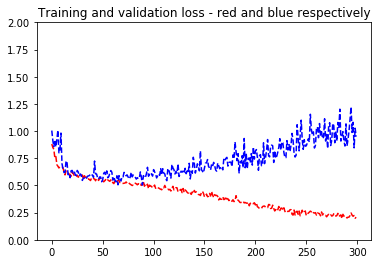

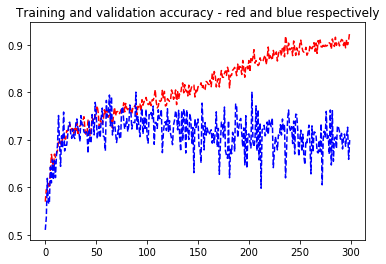

done


In [28]:
saved_dir = 'saved/MaskedVolume_3d/0620_142107'
config_saved_filename = os.path.join(saved_dir, "config.json")
#os.system('tensorboard --logdir ' + log_dir) cannot use with google VM without paying $$$
viewTraining.graphLoss(saved_dir, best=False) #imported from utils

print('done')

In [29]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader_test', config)
    '''
    
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=1,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    '''
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    print(model)
    print(torch.cuda.get_device_name(0))
    normalized = False

    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    criterion = loss_fn(None)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    classes = ('endothelium', 'pct')
    all_pred = []
    all_true = []
    #hm_layers = {'final_layer': 'layer', 'fc_layer': 'fc_layer', 'conv_num': 17, 'fc_num': 3}
    
    #heatmapper = classActivationMap.CAMgenerator(hm_layers, config, model)
    #heatmapper.generateImage(num_images=10)
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            image = np.squeeze(data[0].cpu().data.numpy())
            all_true.extend(target.cpu().data.numpy())
            all_pred.extend(np.argmax(output.cpu().data.numpy(), axis=1))
            
            #
            # save sample images, or do something with output here
            #
            
            
            if i < 5:
                #util.visualizationOutGray(data, output, target, classes, normalized)
                a=1
                
                
                
            # computing loss, metrics on test set
            loss = criterion(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            if output.is_cuda: output = output.cpu()
            if target.is_cuda: target = target.cpu()
            
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        #plt.show()
        
    
    n_samples = len(data_loader.sampler)
    print("num test images = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    for key in log:
        print("{} = {:.4f}".format(key, log[key]))
    #print(log)
    log['classes'] = classes
    log['test_targets'] = all_true
    log['test_predictions'] = all_pred
    print("My_metric is accuracy")
    util.plot_confusion_matrix(all_true, all_pred, classes=classes, normalize=False) 
    


In [30]:
#saved_dir = "saved/GroundTruth_cellData/0529_191042/"
resume = os.path.join(saved_dir, "model_best.pth")

print(os.path.isdir(saved_dir))
print(os.path.exists(resume))

#config = torch.load(saved_dir + "config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


  0%|          | 0/4 [00:00<?, ?it/s]

threeDmodel(
  (conv_layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Leaky

100%|██████████| 4/4 [00:00<00:00,  7.74it/s]


num test images = 230
loss = 0.5533
my_metric = 0.7696
f1 = 0.7664
balanced_accuracy = 0.7692
precision = 0.7862
recall = 0.7696
My_metric is accuracy
Confusion matrix, without normalization
[[88 23]
 [30 89]]


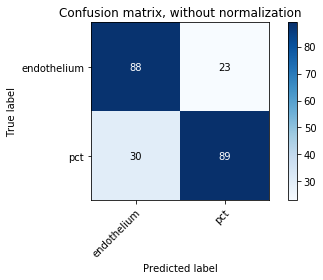

In [32]:
#Test
main2(config, resume)